In [2]:
#import libraries
from bs4 import BeautifulSoup
import pandas as pd
import requests
import datetime as dt
import time
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
%matplotlib inline

## Webscraping and Cleaning

In this notebook I will webscrape NBA headlines and use clustering to try and uncover what topics are discussed. I will be webscraping from the [NBA archives on ESPN](http://www.espn.com/nba/news/archive). The website is fairly simple and lists the title of each article along with a timestamp. It's organized by month and year which will make it convenient to select which years to scrape and analyze. 

I'll start by webscraping headlines from January 2020 so I can get an idea of what we need to pull out of the HTML. I'll be using BeautifulSoup to parse through the content of the webpage.

In [2]:
#request a single webpage to examine elements

headlines_page = requests.get("http://www.espn.com/nba/news/archive/_/month/january/year/2020")
soup = BeautifulSoup(headlines_page.content,'lxml')

In [3]:
#view contents within <li> tags which contain headline titles
headline_title = soup.find_all("li")
headline_title

[<li><a href="http://www.espn.com/nba/story/_/id/28610796/kyrie-irving-puts-54-points-chicago-bulls-kobe-mentality" title="Kyrie puts 54 points on the Bulls with 'Kobe mentality'">Kyrie puts 54 points on the Bulls with 'Kobe mentality'</a> (February 1, 2020, 2:41 AM ET)</li>,
 <li><a href="http://www.espn.com/nba/preview?gameId=401161373" title="Hot-shooting Irving, Nets visit Wizards">Hot-shooting Irving, Nets visit Wizards</a> (February 1, 2020, 2:04 AM ET)</li>,
 <li><a href="http://www.espn.com/nba/story/_/id/28607660/the-lakers-blazers-put-show-honoring-kobe-bryant" title="The Lakers and Blazers put on a show in honoring Kobe Bryant">The Lakers and Blazers put on a show in honoring Kobe Bryant</a> (February 1, 2020, 2:03 AM ET)</li>,
 <li><a href="http://www.espn.com/nba/story/_/id/28610751/zion-williamson-swaps-jerseys-ja-morant-dominating-grizzlies" title="Zion swaps jerseys with Ja after dominating Grizz">Zion swaps jerseys with Ja after dominating Grizz</a> (February 1, 2020, 

In [4]:
#pull text from <li> tags and store in list
titles_list = [headline_title[i].text for i in range(0,len(headline_title))] 
titles_list #preview the list

["Kyrie puts 54 points on the Bulls with 'Kobe mentality' (February 1, 2020, 2:41 AM ET)",
 'Hot-shooting Irving, Nets visit Wizards (February 1, 2020, 2:04 AM ET)',
 'The Lakers and Blazers put on a show in honoring Kobe Bryant (February 1, 2020, 2:03 AM ET)',
 'Zion swaps jerseys with Ja after dominating Grizz (February 1, 2020, 2:00 AM ET)',
 "Kyrie uses 'Mamba mentality' to drop 54 on Bulls (February 1, 2020, 1:43 AM ET)",
 'LeBron reveals Black Mamba tattoo saluting Kobe (February 1, 2020, 1:31 AM ET)',
 "Pelicans' Hayes sorry for vulgar Rising Stars rant (February 1, 2020, 1:28 AM ET)",
 "Giannis starts with brother for Bucks' Greek Night (February 1, 2020, 1:27 AM ET)",
 'Barton, Nuggets hand Bucks rare defeat at home, 127-115 (February 1, 2020, 1:08 AM ET)',
 'Thunder rally in final minutes, push past Suns 111-107 (February 1, 2020, 12:50 AM ET)',
 "Raptors' Nurse to coach Team Giannis in ASG (February 1, 2020, 12:19 AM ET)",
 'Zion scores 24, Pelicans pound Memphis 139-111 (Fe

We can that by pulling the text from the `<li>` tags that we get all of the headlines along with their respective timestamp. There is some additional information that has been pulled out as well so we'll need to further filter this list so that we can just have headlines and timestamps.

Each headline has an associated timestamp that is surrounded by parentheses so we can search in each string to make sure that we have an open and closed parentheses which should correspond to a headline.

In [5]:
#filter list to only include headlines by searching for open and closed parentheses
headlines_only_list = []
for item in titles_list:
    if '(' and ')' not in item: #search for open and closed parentheses in the string
        continue 
    else:
        headlines_only_list.append(item)

In [6]:
#preview the list to make sure only headlines are included
headlines_only_list


["Kyrie puts 54 points on the Bulls with 'Kobe mentality' (February 1, 2020, 2:41 AM ET)",
 'Hot-shooting Irving, Nets visit Wizards (February 1, 2020, 2:04 AM ET)',
 'The Lakers and Blazers put on a show in honoring Kobe Bryant (February 1, 2020, 2:03 AM ET)',
 'Zion swaps jerseys with Ja after dominating Grizz (February 1, 2020, 2:00 AM ET)',
 "Kyrie uses 'Mamba mentality' to drop 54 on Bulls (February 1, 2020, 1:43 AM ET)",
 'LeBron reveals Black Mamba tattoo saluting Kobe (February 1, 2020, 1:31 AM ET)',
 "Pelicans' Hayes sorry for vulgar Rising Stars rant (February 1, 2020, 1:28 AM ET)",
 "Giannis starts with brother for Bucks' Greek Night (February 1, 2020, 1:27 AM ET)",
 'Barton, Nuggets hand Bucks rare defeat at home, 127-115 (February 1, 2020, 1:08 AM ET)',
 'Thunder rally in final minutes, push past Suns 111-107 (February 1, 2020, 12:50 AM ET)',
 "Raptors' Nurse to coach Team Giannis in ASG (February 1, 2020, 12:19 AM ET)",
 'Zion scores 24, Pelicans pound Memphis 139-111 (Fe

Fortunately, it seems that using a conditional statement to check for parentheses helps to filter this list.  The next step is to split the headline from the timestamp. The timestamp is useful for analysis over time, but it would only add to the complexity when tokenizing the headline itself. Therefore we need to write a function that will split headlines from timestamps and then pair them back up in a dataframe.

In [7]:
#isolating timestap with regular expressions
txt = headlines_only_list[0]
pattern = '\((.*)\)'
x = re.search(pattern, txt)
x.group().replace('(', '').replace(')', '')



'February 1, 2020, 2:41 AM ET'

In [8]:
#
txt2 = headlines_only_list[0]
pattern = '\((.*)\)'
new_string = re.sub(pattern, repl='', string=txt2)
new_string.strip()

"Kyrie puts 54 points on the Bulls with 'Kobe mentality'"

I elected to use the `.rfind()` method rather than regular expressions since we have uniformity in the way each headline is structured.  The `.rfind()` method will search the string in reverse and find the index of the character that you are searching for. We can search for the last two parentheses and pull out the timestamp in between. We can also use the index of the first parentheses as the stopping point for just the headline. 

In [9]:
start_num = headlines_only_list[0].rfind('(') #use reverse find method to find last open parentheses
end_num = headlines_only_list[0].rfind(')') #use reverse find method to find last closed parentheses

headlines_only_list[0][start_num+1:end_num] #use indices from reverse find to pull out date from string

'February 1, 2020, 2:41 AM ET'

By storing the index in a variable we can index the selected string to make sure that we are just looking at the headline.

In [10]:
headlines_only_list[0][:start_num].strip()

"Kyrie puts 54 points on the Bulls with 'Kobe mentality'"

I'll create a function that will return the headline and timestamp for each string in the `headlines_only_list` and then store each list in a dataframe.

In [11]:
def clean_headlines(headline_list):
    """This function takes a string as an argument and will split the string into two separate comoponents:
    the headline and timestamp. Input string should be formatted as: 'Headline' (Timestamp). This function
    works best with headlines scraped from ESPN article archives."""
    
    rm_timestamp_list = [] #create empty list for headlines without timestamps
    timestamps_list = []   #create empty list for timestamps of headlines
    for i in headline_list:
        timestamp_start = i.rfind('(') #assign index value of last open parentheses to variable
        timestamp_end = i.rfind(')')   #assign index value of last closed parentheses to variable
        last_comma = i.rfind(',')      #assign index value of last comma to  a variable
        
        rm_timestamp_list.append(i[:timestamp_start].strip())
        
        timestamps_list.append(i[timestamp_start+1:last_comma])
        
        
    return rm_timestamp_list, timestamps_list
        
        

In [12]:
headlines_clean_list, timestamp_strings_list = clean_headlines(headlines_only_list)

In [13]:
headlines_clean_list

["Kyrie puts 54 points on the Bulls with 'Kobe mentality'",
 'Hot-shooting Irving, Nets visit Wizards',
 'The Lakers and Blazers put on a show in honoring Kobe Bryant',
 'Zion swaps jerseys with Ja after dominating Grizz',
 "Kyrie uses 'Mamba mentality' to drop 54 on Bulls",
 'LeBron reveals Black Mamba tattoo saluting Kobe',
 "Pelicans' Hayes sorry for vulgar Rising Stars rant",
 "Giannis starts with brother for Bucks' Greek Night",
 'Barton, Nuggets hand Bucks rare defeat at home, 127-115',
 'Thunder rally in final minutes, push past Suns 111-107',
 "Raptors' Nurse to coach Team Giannis in ASG",
 'Zion scores 24, Pelicans pound Memphis 139-111',
 'Irving scores season-high 54, Nets beat Bulls 133-118',
 'Harden has 35 as Rockets beat Mavericks 128-121',
 "Raptors' streak at 10 after 105-92 win over Pistons",
 "Emotional Melo 'not ready,' to sit out vs. Lakers",
 'Spurs face critical game against hapless Hornets',
 "Mavs' Doncic has sprain, out at least 6 games",
 "Warriors, Cavs matc

In [14]:
#store headlines and timestamps in dataframe
df = pd.DataFrame({'headlines': headlines_clean_list, 'posted_time': timestamp_strings_list})
df.head()

headlines       posted_time
0  Kyrie puts 54 points on the Bulls with 'Kobe m...  February 1, 2020
1            Hot-shooting Irving, Nets visit Wizards  February 1, 2020
2  The Lakers and Blazers put on a show in honori...  February 1, 2020
3  Zion swaps jerseys with Ja after dominating Grizz  February 1, 2020
4   Kyrie uses 'Mamba mentality' to drop 54 on Bulls  February 1, 2020

In [15]:
df['posted_time'] = pd.to_datetime(df['posted_time'], format='%B %d, %Y') #convert timestamp to datetime object

In [16]:
df.head()

headlines posted_time
0  Kyrie puts 54 points on the Bulls with 'Kobe m...  2020-02-01
1            Hot-shooting Irving, Nets visit Wizards  2020-02-01
2  The Lakers and Blazers put on a show in honori...  2020-02-01
3  Zion swaps jerseys with Ja after dominating Grizz  2020-02-01
4   Kyrie uses 'Mamba mentality' to drop 54 on Bulls  2020-02-01

Now that we have the timestamps and headlines separated we need to tokenize the headlines. For tokenization, I'll use the stopwords from NLTK and I'll choose to lemmatize each of the words. The tokens will be stored in a separate column in the dataframe.

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

In [18]:
def create_tokens(headline_string):
    """This function takes a string as an input and tokenized the string. The functions removes stopwords as
    defined by NLTK and will remove any additiional white space if present in the string."""
    
    no_punc_text = "".join([word for word in headline_string if word not in string.punctuation]) #remove punctuation
    tokens = re.split('\W+', no_punc_text) #split words by in no_punc_text variable by whitespace
    
    #Lemmatize each token and store tokens in a list
    final_tokens = [wnl.lemmatize(word) for word in tokens if word not in stopwords]
    
    return final_tokens

In [19]:
df['headline_tokens'] = df['headlines'].apply(lambda x: create_tokens(x.lower()))

In [20]:
#pd.set_option('display.max_colwidth', -1)
df.head(20)

headlines posted_time  \
0   Kyrie puts 54 points on the Bulls with 'Kobe m...  2020-02-01   
1             Hot-shooting Irving, Nets visit Wizards  2020-02-01   
2   The Lakers and Blazers put on a show in honori...  2020-02-01   
3   Zion swaps jerseys with Ja after dominating Grizz  2020-02-01   
4    Kyrie uses 'Mamba mentality' to drop 54 on Bulls  2020-02-01   
5     LeBron reveals Black Mamba tattoo saluting Kobe  2020-02-01   
6   Pelicans' Hayes sorry for vulgar Rising Stars ...  2020-02-01   
7   Giannis starts with brother for Bucks' Greek N...  2020-02-01   
8   Barton, Nuggets hand Bucks rare defeat at home...  2020-02-01   
9   Thunder rally in final minutes, push past Suns...  2020-02-01   
10        Raptors' Nurse to coach Team Giannis in ASG  2020-02-01   
11     Zion scores 24, Pelicans pound Memphis 139-111  2020-02-01   
12  Irving scores season-high 54, Nets beat Bulls ...  2020-01-31   
13    Harden has 35 as Rockets beat Mavericks 128-121  2020-01-31   
14  Raptors' streak at 10 after 105-92 win over Pi...  2020-01-31   
15  Emotional Melo 'not ready,' to sit out vs. Lakers  2020-01-31   
16   Spurs face critical game against hapless Hornets  2020-01-31   
17      Mavs' Doncic has sprain, out at least 6 games  2020-01-31   
18   Warriors, Cavs matchup notable for who's missing  2020-01-31   
19        Pacers look to continue surge versus Knicks  2020-01-31   

                                      headline_tokens  
0      [kyrie, put, 54, point, bull, kobe, mentality]  
1           [hotshooting, irving, net, visit, wizard]  
2   [lakers, blazer, put, show, honoring, kobe, br...  
3         [zion, swap, jersey, ja, dominating, grizz]  
4       [kyrie, us, mamba, mentality, drop, 54, bull]  
5   [lebron, reveals, black, mamba, tattoo, saluti...  
6   [pelican, hayes, sorry, vulgar, rising, star, ...  
7       [giannis, start, brother, buck, greek, night]  
8   [barton, nugget, hand, buck, rare, defeat, hom...  
9   [thunder, rally, final, minute, push, past, su...  
10         [raptor, nurse, coach, team, giannis, asg]  
11  [zion, score, 24, pelican, pound, memphis, 139...  
12  [irving, score, seasonhigh, 54, net, beat, bul...  
13       [harden, 35, rocket, beat, maverick, 128121]  
14           [raptor, streak, 10, 10592, win, piston]  
15           [emotional, melo, ready, sit, v, lakers]  
16      [spur, face, critical, game, hapless, hornet]  
17             [mavs, doncic, sprain, least, 6, game]  
18    [warrior, cavs, matchup, notable, who, missing]  
19     [pacer, look, continue, surge, versus, knicks]

## Vectorizing the Data

I'll be using the `TfidfVectorizer` from sklearn to vectorize each headline.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
#create tfidf matrix from headlines
tfidf_vec = TfidfVectorizer(stop_words=stopwords)
X_tfidf = tfidf_vec.fit_transform(df['headlines'])


In [23]:
print(X_tfidf.shape)

(885, 1735)


Just looking at the shape of the dataframe from January 2020, we can see that we have 885 headlines and 1735 unique tokens.  

In [24]:
tfidf_df = pd.DataFrame(X_tfidf.toarray())
tfidf_df.columns = tfidf_vec.get_feature_names()

In [25]:
#preview some of the columns (i.e. unique tokens) and their tfidf scores
pd.set_option('max_columns', 10)
tfidf_df.head()

000   10  100  101  102  ...  youngest  zach  zaza      zion  zizic
0  0.0  0.0  0.0  0.0  0.0  ...       0.0   0.0   0.0  0.000000    0.0
1  0.0  0.0  0.0  0.0  0.0  ...       0.0   0.0   0.0  0.000000    0.0
2  0.0  0.0  0.0  0.0  0.0  ...       0.0   0.0   0.0  0.000000    0.0
3  0.0  0.0  0.0  0.0  0.0  ...       0.0   0.0   0.0  0.270419    0.0
4  0.0  0.0  0.0  0.0  0.0  ...       0.0   0.0   0.0  0.000000    0.0

[5 rows x 1735 columns]

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
%matplotlib inline

After creating a TFIDF matrix for the January 2020 headlines we can perform KMeans clustering and calculate the Calinski-Harabasz score on this dataframe to see if there are distinct number of clusters.

Text(0, 0.5, 'Calinski Harabasz Score')

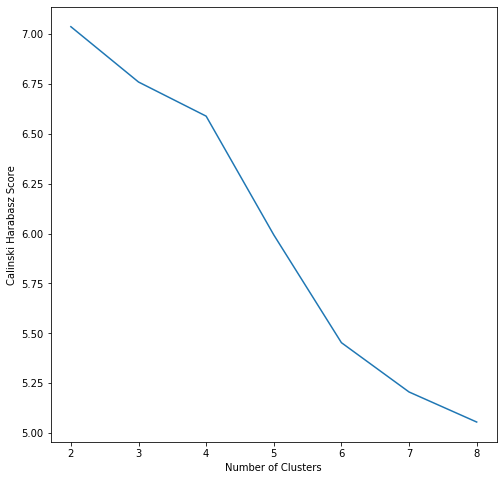

In [27]:
ch_score_vals = []

#create loop to run through KMeans clustering using different values of k
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(tfidf_df)
    cluster_assignments = kmeans.predict(tfidf_df)
    ch_score = calinski_harabasz_score(tfidf_df, cluster_assignments)
    ch_score_vals.append(ch_score)

#plot Calinski-Harabasz score for each cluster K for January 2020
plt.figure(figsize=(8,8))
plt.plot(list(range(2,9)), ch_score_vals)
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')

Looking at the graph above, there seems to be a clear elbow at 4 clusters. We can't simply rely on one month's worth of headlines. I'm going to choose to collect headlines from January 2016 (which would be a few months after the start of the 2016-17 season) and go up to February 2021. I chose not to include March 2021 (the month in which I'm finishing this project) because the month is not yet complete.

Below I wrote a function that will take a month and year as an input and scrape the respective headlines from that page.

In [28]:
def grab_espn_webpage(month, year):
    
    """This function takes a month and year as input. The month should be lowercase and a string 
    (i.e. 'january'). The year should be a four digit integer (i.e. 2020). The function will check for 
    status errors 500 and 503. It can be modified to included other status errors. The function will attempt 
    a request for 5 times in case the webpage does not respond. If the webpage does not respond then the function
    should return a None object."""
    
    sess = Session() #create session
    
    #specify session to retry 5 times if it encouters a 500 or 503 error
    sess.mount('http://www.espn.com/nba/news/archive', 
               HTTPAdapter(max_retries=Retry(total=5, status_forcelist=[500, 503], backoff_factor=3)))
    
    url = f"http://www.espn.com/nba/news/archive/_/month/{month}/year/{year}"
    webpage = sess.get(url)
    
        
    soup_contents = BeautifulSoup(webpage.content,'lxml')
    
  
    headline_title_content = soup_contents.find_all("li") #find all <li> tags in the soup
    
    webpage_text = [headline_title_content[i].text for i in range(0,len(headline_title_content))] 
    
    headlines_dates = []
    for item in webpage_text:
        if '(' and ')' not in item:
            continue
        else:
            headlines_dates.append(item)
            
    headlines_only, dates_only = clean_headlines(headlines_dates) #use previous function to split headlines/dates
    
    df_standard = pd.DataFrame({'headlines': headlines_only, 'posted_time': dates_only})
    df_standard['tokens'] = df_standard['headlines'].apply(lambda x: create_tokens(x.lower()))
    df_standard['posted_time'] = pd.to_datetime(df_standard['posted_time'], format='%B %d, %Y')
    
    return df_standard #function will return dataframe with all headlines and timestamps from specified month/year
            
    
    

The following cells will scrape the ESPN NBA archives for each month and year between January 2016 to February 2021 and store them in a variable so that we can perform clustering on the entire scraped dataset.

In [29]:
#get ESPN headlines for an entire year
jan2016 = grab_espn_webpage('january', 2016)
feb2016 = grab_espn_webpage('february', 2016)
mar2016 = grab_espn_webpage('march', 2016)
apr2016 = grab_espn_webpage('april', 2016)

may2016 = grab_espn_webpage('may', 2016)
jun2016 = grab_espn_webpage('june', 2016)
jul2016 = grab_espn_webpage('july', 2016)
aug2016 = grab_espn_webpage('august', 2016)

sept2016 = grab_espn_webpage('september', 2016)
oct2016 = grab_espn_webpage('october', 2016)
nov2016 = grab_espn_webpage('november', 2016)
dec2016 = grab_espn_webpage('december', 2016)

In [30]:
#get ESPN headlines for an entire year

jan2017 = grab_espn_webpage('january', 2017)
feb2017 = grab_espn_webpage('february', 2017)
mar2017 = grab_espn_webpage('march', 2017)
apr2017 = grab_espn_webpage('april', 2017)

may2017 = grab_espn_webpage('may', 2017)
jun2017 = grab_espn_webpage('june', 2017)
jul2017 = grab_espn_webpage('july', 2017)
aug2017 = grab_espn_webpage('august', 2017)

sept2017 = grab_espn_webpage('september', 2017)
oct2017 = grab_espn_webpage('october', 2017)
nov2017 = grab_espn_webpage('november', 2017)
dec2017 = grab_espn_webpage('december', 2017)

In [31]:
jan2018 = grab_espn_webpage('january', 2018)
feb2018 = grab_espn_webpage('february', 2018)
mar2018 = grab_espn_webpage('march', 2018)
apr2018 = grab_espn_webpage('april', 2018)

may2018 = grab_espn_webpage('may', 2018)
jun2018 = grab_espn_webpage('june', 2018)
jul2018 = grab_espn_webpage('july', 2018)
aug2018 = grab_espn_webpage('august', 2018)

sept2018 = grab_espn_webpage('september', 2018)
oct2018 = grab_espn_webpage('october', 2018)
nov2018 = grab_espn_webpage('november', 2018)
dec2018 = grab_espn_webpage('december', 2018)

In [32]:
jan2019 = grab_espn_webpage('january', 2019)
feb2019 = grab_espn_webpage('february', 2019)
mar2019 = grab_espn_webpage('march', 2019)
apr2019 = grab_espn_webpage('april', 2019)

may2019 = grab_espn_webpage('may', 2019)
jun2019 = grab_espn_webpage('june', 2019)
jul2019 = grab_espn_webpage('july', 2019)
aug2019 = grab_espn_webpage('august', 2019)

sept2019 = grab_espn_webpage('september', 2019)
oct2019 = grab_espn_webpage('october', 2019)
nov2019 = grab_espn_webpage('november', 2019)
dec2019 = grab_espn_webpage('december', 2019)

In [33]:
jan2020 = grab_espn_webpage('january', 2020)
feb2020 = grab_espn_webpage('february', 2020)
mar2020 = grab_espn_webpage('march', 2020)
apr2020 = grab_espn_webpage('april', 2020)

may2020 = grab_espn_webpage('may', 2020)
jun2020 = grab_espn_webpage('june', 2020)
jul2020 = grab_espn_webpage('july', 2020)
aug2020 = grab_espn_webpage('august', 2020)

sept2020 = grab_espn_webpage('september', 2020)
oct2020 = grab_espn_webpage('october', 2020)
nov2020 = grab_espn_webpage('november', 2020)
dec2020 = grab_espn_webpage('december', 2020)

In [34]:
jan2021 = grab_espn_webpage('january', 2021)
feb2021 = grab_espn_webpage('february', 2021)

## Iterative Clustering per Month

In [35]:
#import KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer

yellowbrick.cluster.elbow.KElbowVisualizer

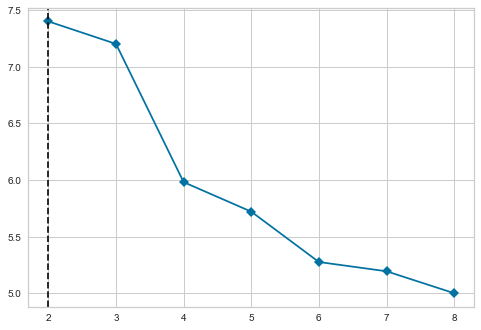

In [36]:
#Use KElbowVisualizer to see if visualizer will identify a specific elbow
model_ = KMeans()
visualizer_ = KElbowVisualizer(model_, k=(2,9), metric = 'calinski_harabasz', timings=False)
type(visualizer_.fit(tfidf_df))

Below is a function that will take each of the month dataframes created above and create a TFIDF matrix for each month. We will then look at a Calinski-Harabasz plot for each month to see if the number of clusters is consistent across months.

In [37]:
def tfidf_vectorizer(dataframe):
    """This function takes a dataframe with headlines and will reutrn a tfidf dataframe of vectorized tokens.
    The strings that will be tokenized should be in a column called 'headlines'."""
    
    tfidf = TfidfVectorizer(stop_words=stopwords)
    month_tfidf = tfidf.fit_transform(dataframe['headlines'])
    
    month_df = pd.DataFrame(month_tfidf.toarray())
    month_df.columns = tfidf.get_feature_names()
    
    return month_df

In [38]:
#create tfidf matrices for each month in a year
jan16_tfidf = tfidf_vectorizer(jan2016)
feb16_tfidf = tfidf_vectorizer(feb2016)
mar16_tfidf = tfidf_vectorizer(mar2016)
apr16_tfidf = tfidf_vectorizer(apr2016)

may16_tfidf = tfidf_vectorizer(may2016)
jun16_tfidf = tfidf_vectorizer(jun2016)
jul16_tfidf = tfidf_vectorizer(jul2016)
aug16_tfidf = tfidf_vectorizer(aug2016)

sept16_tfidf = tfidf_vectorizer(sept2016)
oct16_tfidf = tfidf_vectorizer(oct2016)
nov16_tfidf = tfidf_vectorizer(nov2016)
dec16_tfidf = tfidf_vectorizer(dec2016)



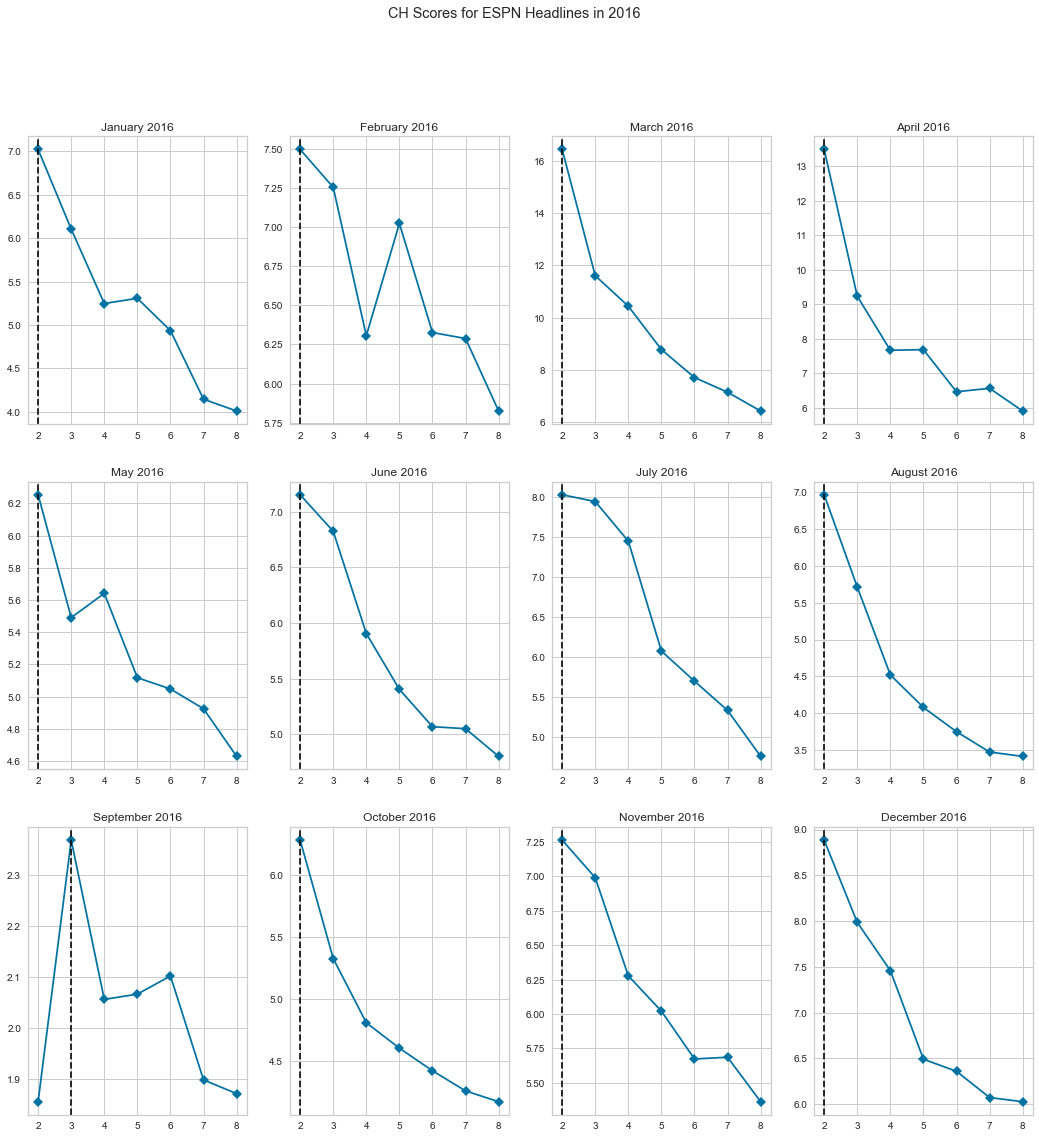

In [39]:
#create subplots to look at Calinski Harabasz plot for each month in year 
#below code is the same for each month 

fig, axs = plt.subplots(3, 4, figsize=(18,18))
kmeans = KMeans()

jan_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,0])
jan_viz.fit(jan16_tfidf)
axs[0,0].set_title('January 2016');

feb_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,1])
feb_viz.fit(feb16_tfidf)
axs[0,1].set_title('February 2016');

mar_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,2])
mar_viz.fit(mar16_tfidf)
axs[0,2].set_title('March 2016');

apr_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,3])
apr_viz.fit(apr16_tfidf)
axs[0,3].set_title('April 2016');

may_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,0])
may_viz.fit(may16_tfidf)
axs[1,0].set_title('May 2016');

jun_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,1])
jun_viz.fit(jun16_tfidf)
axs[1,1].set_title('June 2016');

jul_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,2])
jul_viz.fit(jul16_tfidf)
axs[1,2].set_title('July 2016');

aug_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,3])
aug_viz.fit(aug16_tfidf)
axs[1,3].set_title('August 2016');

sept_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,0])
sept_viz.fit(sept16_tfidf)
axs[2,0].set_title('September 2016');

oct_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,1])
oct_viz.fit(oct16_tfidf)
axs[2,1].set_title('October 2016');

nov_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,2])
nov_viz.fit(nov16_tfidf)
axs[2,2].set_title('November 2016');

dec_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,3])
dec_viz.fit(dec16_tfidf)
axs[2,3].set_title('December 2016');

plt.suptitle('CH Scores for ESPN Headlines in 2016')
plt.savefig('espn_ch_scores_2016.png')


In [40]:
jan17_tfidf = tfidf_vectorizer(jan2017)
feb17_tfidf = tfidf_vectorizer(feb2017)
mar17_tfidf = tfidf_vectorizer(mar2017)
apr17_tfidf = tfidf_vectorizer(apr2017)

may17_tfidf = tfidf_vectorizer(may2017)
jun17_tfidf = tfidf_vectorizer(jun2017)
jul17_tfidf = tfidf_vectorizer(jul2017)
aug17_tfidf = tfidf_vectorizer(aug2017)

sept17_tfidf = tfidf_vectorizer(sept2017)
oct17_tfidf = tfidf_vectorizer(oct2017)
nov17_tfidf = tfidf_vectorizer(nov2017)
dec17_tfidf = tfidf_vectorizer(dec2017)

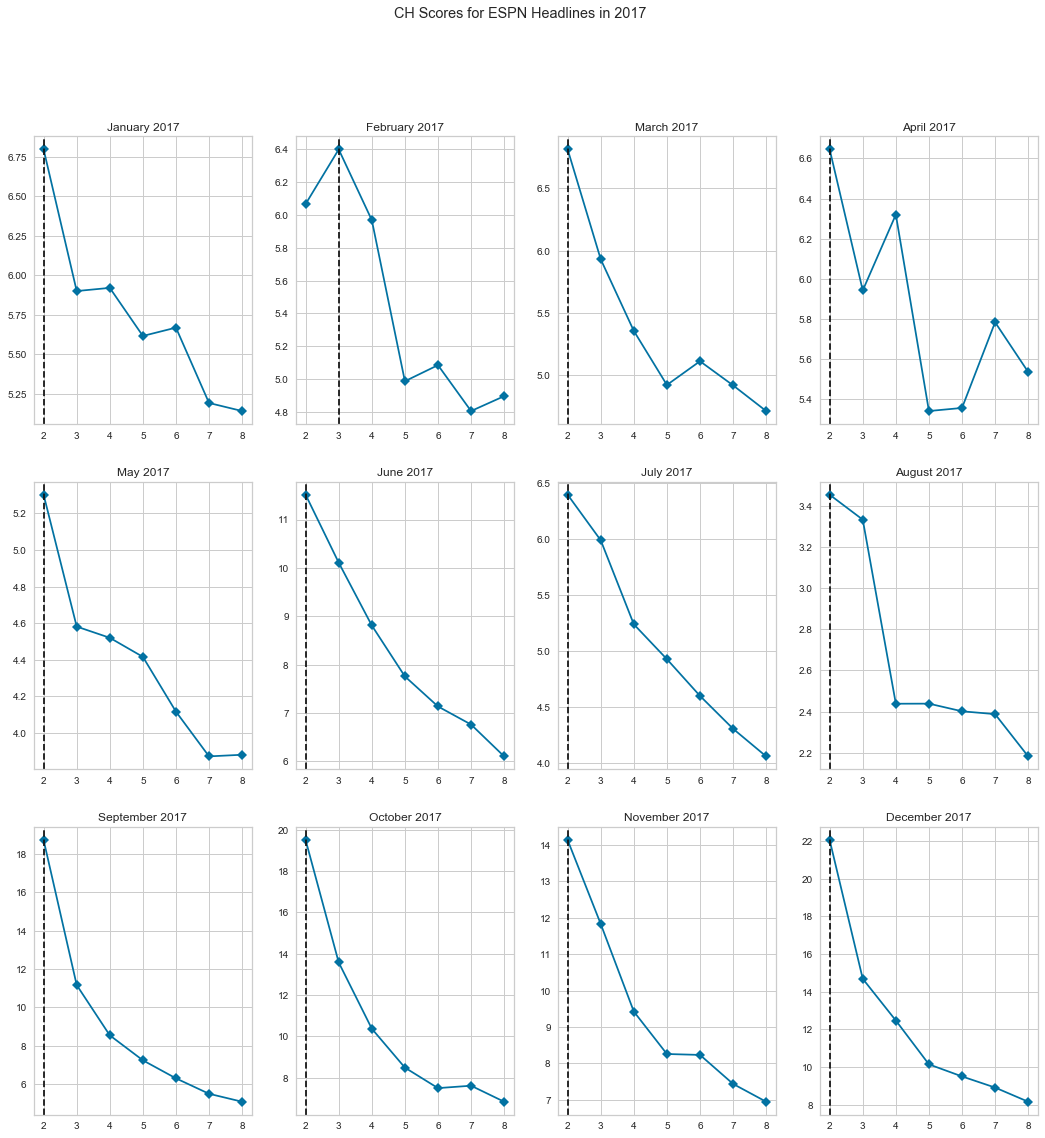

In [41]:
fig, axs = plt.subplots(3, 4, figsize=(18,18))
kmeans = KMeans()

jan_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,0])
jan_viz.fit(jan17_tfidf)
axs[0,0].set_title('January 2017')

feb_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,1])
feb_viz.fit(feb17_tfidf)
axs[0,1].set_title('February 2017')

mar_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,2])
mar_viz.fit(mar17_tfidf)
axs[0,2].set_title('March 2017')

apr_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,3])
apr_viz.fit(apr17_tfidf)
axs[0,3].set_title('April 2017')

may_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,0])
may_viz.fit(may17_tfidf)
axs[1,0].set_title('May 2017')

jun_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,1])
jun_viz.fit(jun17_tfidf)
axs[1,1].set_title('June 2017')

jul_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,2])
jul_viz.fit(jul17_tfidf)
axs[1,2].set_title('July 2017')

aug_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,3])
aug_viz.fit(aug17_tfidf)
axs[1,3].set_title('August 2017')

sept_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,0])
sept_viz.fit(sept17_tfidf)
axs[2,0].set_title('September 2017')

oct_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,1])
oct_viz.fit(oct17_tfidf)
axs[2,1].set_title('October 2017')

nov_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,2])
nov_viz.fit(nov17_tfidf)
axs[2,2].set_title('November 2017')

dec_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,3])
dec_viz.fit(dec17_tfidf)
axs[2,3].set_title('December 2017')

plt.suptitle('CH Scores for ESPN Headlines in 2017')
plt.savefig('espn_ch_scores_2017.png')

In [42]:
jan18_tfidf = tfidf_vectorizer(jan2018)
feb18_tfidf = tfidf_vectorizer(feb2018)
mar18_tfidf = tfidf_vectorizer(mar2018)
apr18_tfidf = tfidf_vectorizer(apr2018)

may18_tfidf = tfidf_vectorizer(may2018)
jun18_tfidf = tfidf_vectorizer(jun2018)
jul18_tfidf = tfidf_vectorizer(jul2018)
aug18_tfidf = tfidf_vectorizer(aug2018)

sept18_tfidf = tfidf_vectorizer(sept2018)
oct18_tfidf = tfidf_vectorizer(oct2018)
nov18_tfidf = tfidf_vectorizer(nov2018)
dec18_tfidf = tfidf_vectorizer(dec2018)

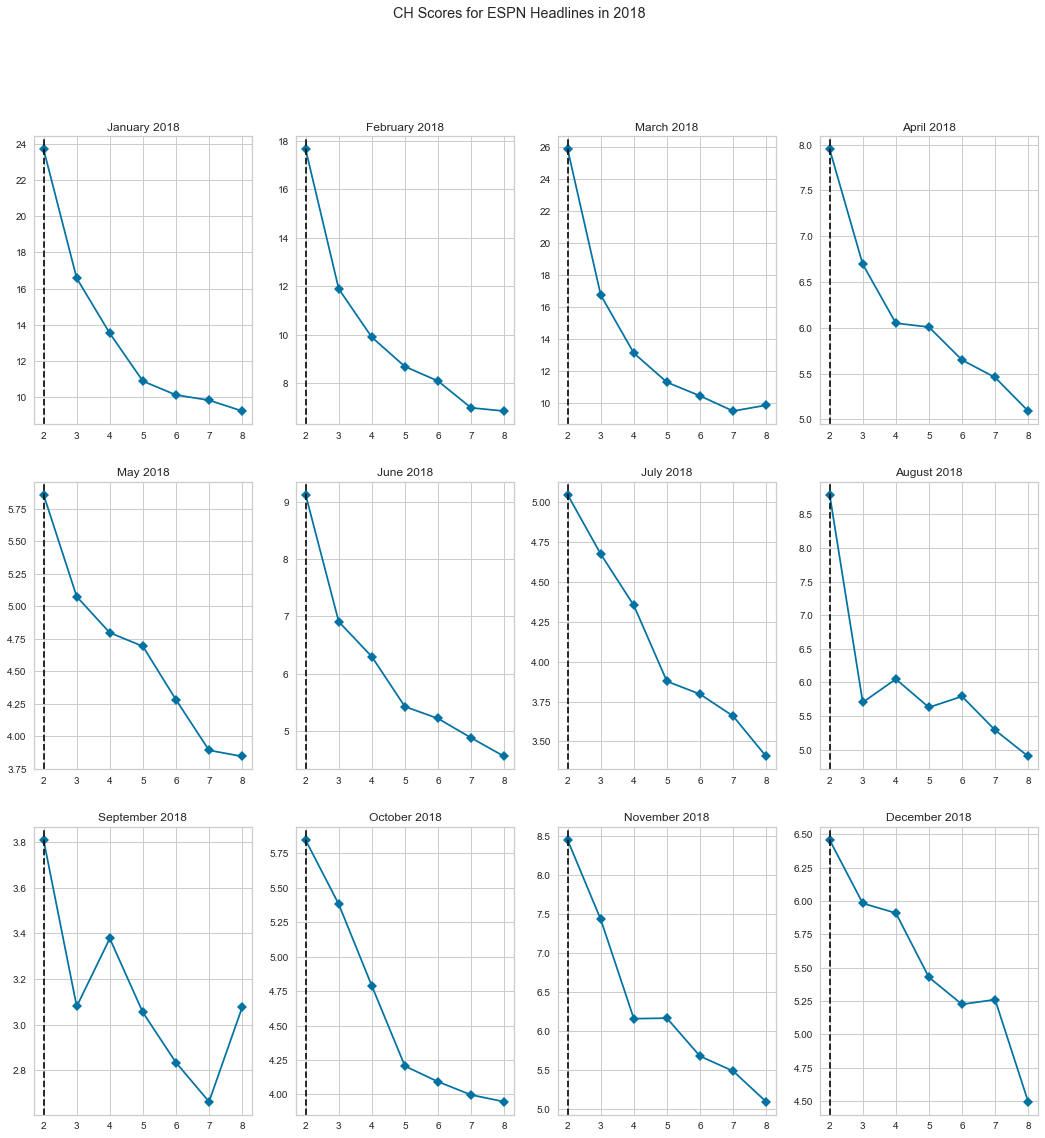

In [43]:
fig, axs = plt.subplots(3, 4, figsize=(18,18))
kmeans = KMeans()

jan_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,0])
jan_viz.fit(jan18_tfidf)
axs[0,0].set_title('January 2018')

feb_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,1])
feb_viz.fit(feb18_tfidf)
axs[0,1].set_title('February 2018')

mar_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,2])
mar_viz.fit(mar18_tfidf)
axs[0,2].set_title('March 2018')

apr_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,3])
apr_viz.fit(apr18_tfidf)
axs[0,3].set_title('April 2018')

may_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,0])
may_viz.fit(may18_tfidf)
axs[1,0].set_title('May 2018')

jun_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,1])
jun_viz.fit(jun18_tfidf)
axs[1,1].set_title('June 2018')

jul_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,2])
jul_viz.fit(jul18_tfidf)
axs[1,2].set_title('July 2018')

aug_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,3])
aug_viz.fit(aug18_tfidf)
axs[1,3].set_title('August 2018')

sept_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,0])
sept_viz.fit(sept18_tfidf)
axs[2,0].set_title('September 2018')

oct_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,1])
oct_viz.fit(oct18_tfidf)
axs[2,1].set_title('October 2018')

nov_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,2])
nov_viz.fit(nov18_tfidf)
axs[2,2].set_title('November 2018')

dec_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,3])
dec_viz.fit(dec18_tfidf)
axs[2,3].set_title('December 2018')

plt.suptitle('CH Scores for ESPN Headlines in 2018')
plt.savefig('espn_ch_scores_2018.png')


In [44]:
jan19_tfidf = tfidf_vectorizer(jan2019)
feb19_tfidf = tfidf_vectorizer(feb2019)
mar19_tfidf = tfidf_vectorizer(mar2019)
apr19_tfidf = tfidf_vectorizer(apr2019)

may19_tfidf = tfidf_vectorizer(may2019)
jun19_tfidf = tfidf_vectorizer(jun2019)
jul19_tfidf = tfidf_vectorizer(jul2019)
aug19_tfidf = tfidf_vectorizer(aug2019)

sept19_tfidf = tfidf_vectorizer(sept2019)
oct19_tfidf = tfidf_vectorizer(oct2019)
nov19_tfidf = tfidf_vectorizer(nov2019)
dec19_tfidf = tfidf_vectorizer(dec2019)

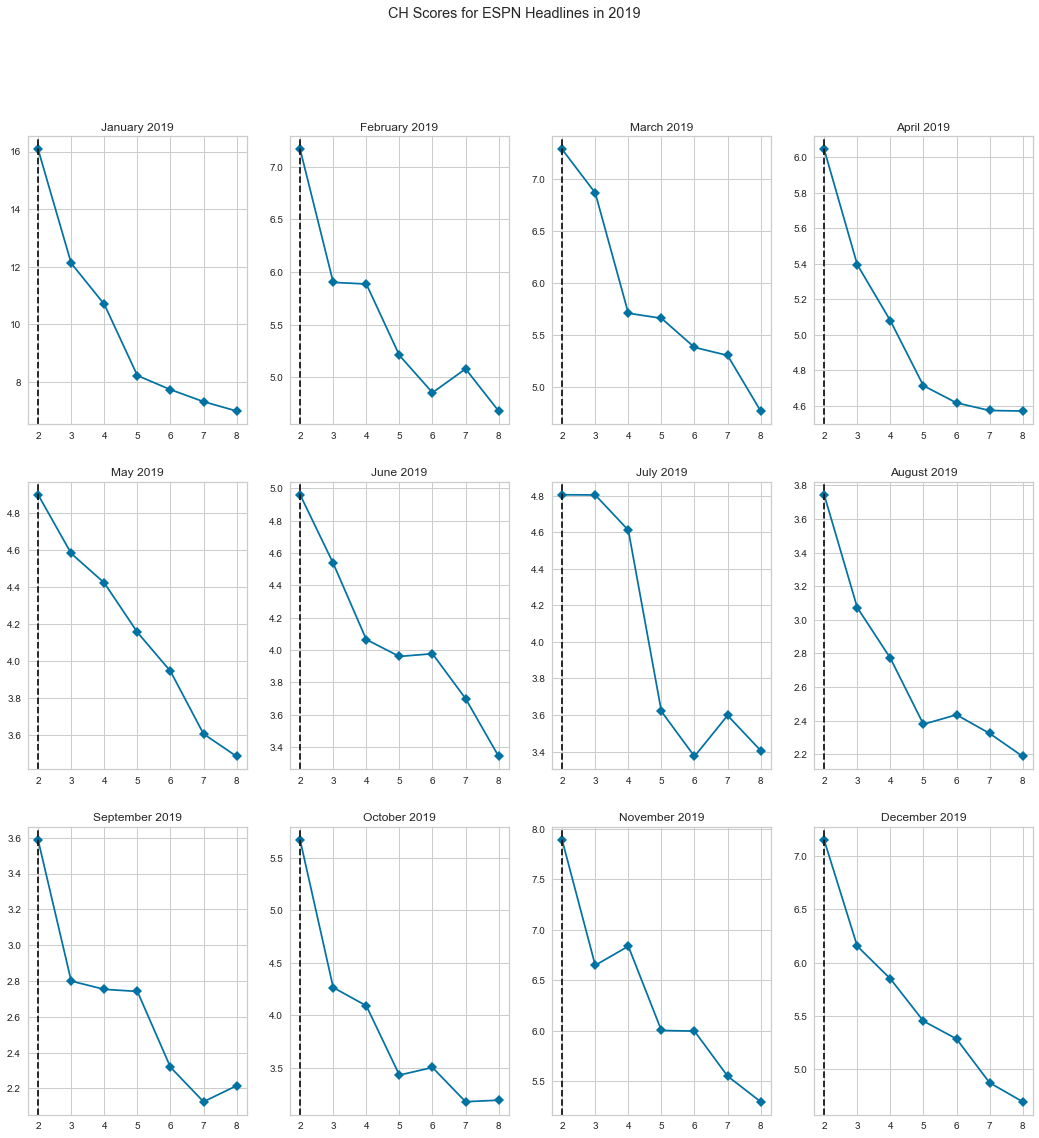

In [45]:
fig, axs = plt.subplots(3, 4, figsize=(18,18))
kmeans = KMeans()

jan_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,0])
jan_viz.fit(jan19_tfidf)
axs[0,0].set_title('January 2019')

feb_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,1])
feb_viz.fit(feb19_tfidf)
axs[0,1].set_title('February 2019')

mar_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,2])
mar_viz.fit(mar19_tfidf)
axs[0,2].set_title('March 2019')

apr_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,3])
apr_viz.fit(apr19_tfidf)
axs[0,3].set_title('April 2019')

may_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,0])
may_viz.fit(may19_tfidf)
axs[1,0].set_title('May 2019')

jun_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,1])
jun_viz.fit(jun19_tfidf)
axs[1,1].set_title('June 2019')

jul_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,2])
jul_viz.fit(jul19_tfidf)
axs[1,2].set_title('July 2019')

aug_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,3])
aug_viz.fit(aug19_tfidf)
axs[1,3].set_title('August 2019')

sept_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,0])
sept_viz.fit(sept19_tfidf)
axs[2,0].set_title('September 2019')

oct_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,1])
oct_viz.fit(oct19_tfidf)
axs[2,1].set_title('October 2019')

nov_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,2])
nov_viz.fit(nov19_tfidf)
axs[2,2].set_title('November 2019')

dec_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,3])
dec_viz.fit(dec19_tfidf)
axs[2,3].set_title('December 2019')

plt.suptitle('CH Scores for ESPN Headlines in 2019')
plt.savefig('espn_ch_scores_2019.png')


In [46]:
jan20_tfidf = tfidf_vectorizer(jan2020)
feb20_tfidf = tfidf_vectorizer(feb2020)
mar20_tfidf = tfidf_vectorizer(mar2020)
apr20_tfidf = tfidf_vectorizer(apr2020)

may20_tfidf = tfidf_vectorizer(may2020)
jun20_tfidf = tfidf_vectorizer(jun2020)
jul20_tfidf = tfidf_vectorizer(jul2020)
aug20_tfidf = tfidf_vectorizer(aug2020)

sept20_tfidf = tfidf_vectorizer(sept2020)
oct20_tfidf = tfidf_vectorizer(oct2020)
nov20_tfidf = tfidf_vectorizer(nov2020)
dec20_tfidf = tfidf_vectorizer(dec2020)

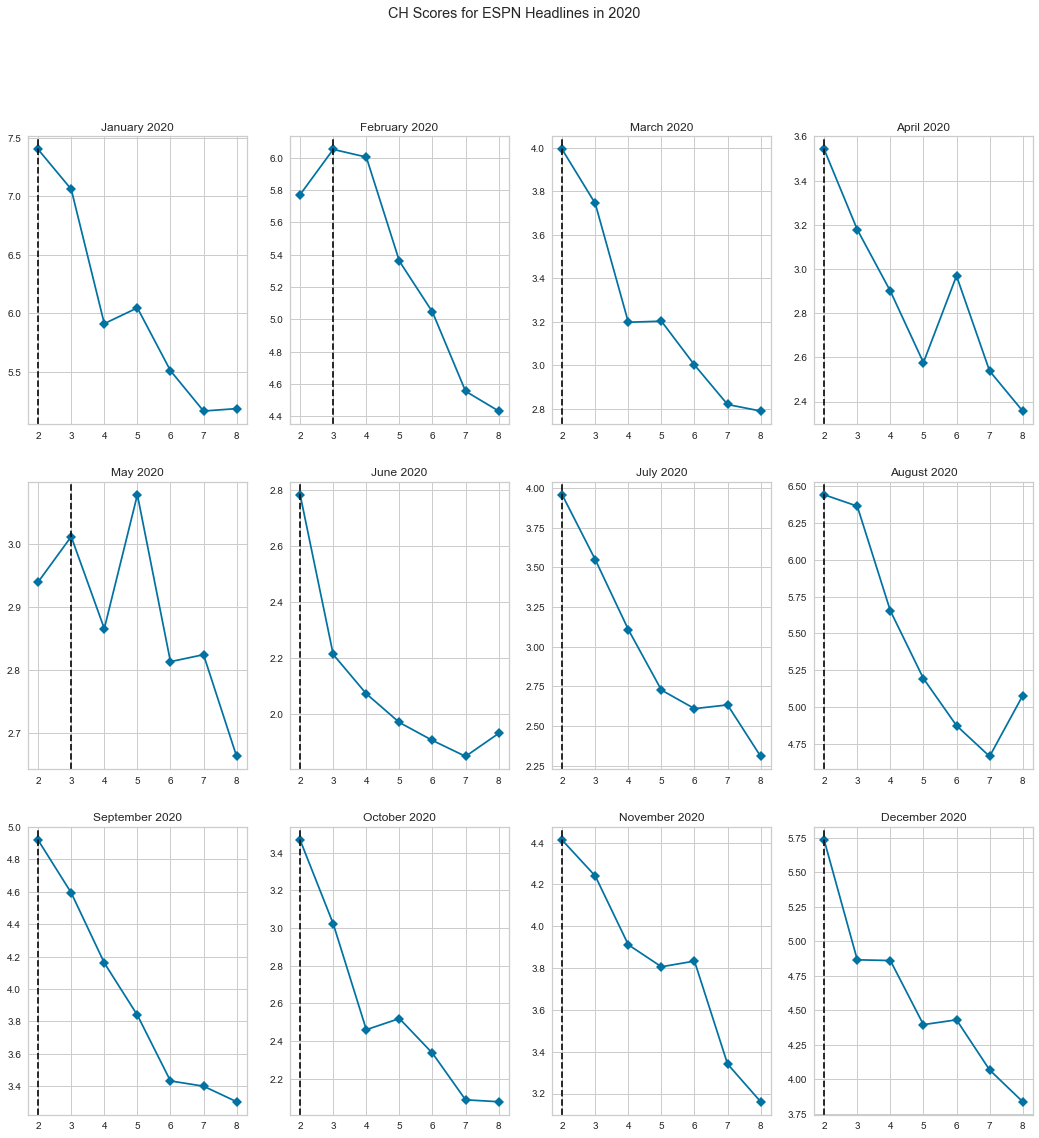

In [47]:
fig, axs = plt.subplots(3, 4, figsize=(18,18))
kmeans = KMeans()

jan_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,0])
jan_viz.fit(jan20_tfidf)
axs[0,0].set_title('January 2020')

feb_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,1])
feb_viz.fit(feb20_tfidf)
axs[0,1].set_title('February 2020')

mar_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,2])
mar_viz.fit(mar20_tfidf)
axs[0,2].set_title('March 2020')

apr_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0,3])
apr_viz.fit(apr20_tfidf)
axs[0,3].set_title('April 2020')

may_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,0])
may_viz.fit(may20_tfidf)
axs[1,0].set_title('May 2020')

jun_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,1])
jun_viz.fit(jun20_tfidf)
axs[1,1].set_title('June 2020')

jul_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,2])
jul_viz.fit(jul20_tfidf)
axs[1,2].set_title('July 2020')

aug_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1,3])
aug_viz.fit(aug20_tfidf)
axs[1,3].set_title('August 2020')

sept_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,0])
sept_viz.fit(sept20_tfidf)
axs[2,0].set_title('September 2020')

oct_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,1])
oct_viz.fit(oct20_tfidf)
axs[2,1].set_title('October 2020')

nov_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,2])
nov_viz.fit(nov20_tfidf)
axs[2,2].set_title('November 2020')

dec_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[2,3])
dec_viz.fit(dec20_tfidf)
axs[2,3].set_title('December 2020')

plt.suptitle('CH Scores for ESPN Headlines in 2020')
plt.savefig('espn_ch_scores_2020.png')


In [48]:
jan21_tfidf = tfidf_vectorizer(jan2021)
feb21_tfidf = tfidf_vectorizer(feb2021)

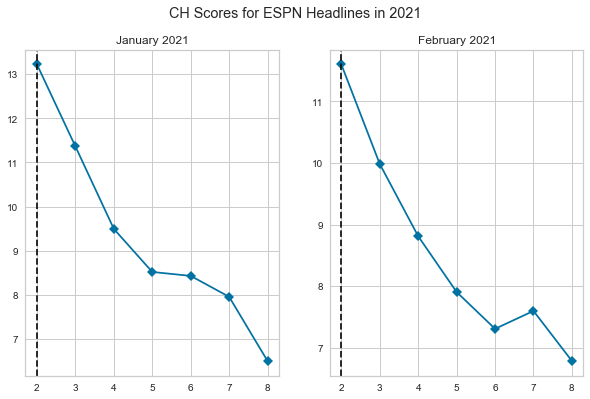

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10,6))
kmeans = KMeans()

jan_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[0])
jan_viz.fit(jan21_tfidf)
axs[0].set_title('January 2021')

feb_viz = KElbowVisualizer(kmeans, k=(2,9), metric = 'calinski_harabasz', timings=False, ax=axs[1])
feb_viz.fit(feb21_tfidf)
axs[1].set_title('February 2021')

plt.suptitle('CH Scores for ESPN Headlines in 2021')
plt.savefig('espn_ch_scores_2021.png')

Looking at the Calinski-Harabasz plot for each month, the KElbow Visualizer places the optimal number of clusters as two for most months. Visually inspecting, we can see that elbows often occur at clusters of 3 or 4. We should expect each of the plots to look different considering that in a given month, there will be different topics covered by ESPN. Also we can't expect to the Calinski-Harabasz score to be that high because we might have on the order of 1000 headlines during months in the regular season while we only have around 200 headlines for months in the offseason. Each group of headlines is also going to have a different set of tokens so that will cause variability between each of the plots as well. Each of the plots does trend downward as we increase the number of clusters (which is expected) so we will start with a smaller number of clusters and see if those clusters have well defined topics.

Below I calculated the number of headlines in each year and we will see that the number of headlines isn't consistent across year or across months.  2020 obviously stands out from a typical year due to the onset of the COVID-19 pandemic which threw the NBA season into disarray before its eventual resumption in late July.

##  Combining All Headlines

In [50]:
espn16 = [len(jan2016), len(feb2016), len(mar2016), len(apr2016), len(may2016), len(jun2016), len(jul2016),
 len(aug2016), len(sept2016), len(oct2016), len(nov2016), len(dec2016)]

espn17 = [len(jan2017), len(feb2017), len(mar2017), len(apr2017), len(may2017), len(jun2017), len(jul2017),
 len(aug2017), len(sept2017), len(oct2017), len(nov2017), len(dec2017)]

espn18 = [len(jan2018), len(feb2018), len(mar2018), len(apr2018), len(may2018), len(jun2018), len(jul2018),
 len(aug2018), len(sept2018), len(oct2018), len(nov2018), len(dec2018)]

espn19 = [len(jan2019), len(feb2019), len(mar2019), len(apr2019), len(may2019), len(jun2019), len(jul2019),
 len(aug2019), len(sept2019), len(oct2019), len(nov2019), len(dec2019)]

espn20 = [len(jan2020), len(feb2020), len(mar2020), len(apr2020), len(may2020), len(jun2020), len(jul2020),
 len(aug2020), len(sept2020), len(oct2020), len(nov2020), len(dec2020)]

espn21 = [len(jan2021), len(feb2021)]

In [51]:
#check number of headlines in each year
print(f"Number of ESPN NBA Headlines in 2016: {sum(espn16)}")
print(f"Number of ESPN NBA Headlines in 2017: {sum(espn17)}")
print(f"Number of ESPN NBA Headlines in 2018: {sum(espn18)}")
print(f"Number of ESPN NBA Headlines in 2019: {sum(espn19)}")
print(f"Number of ESPN NBA Headlines in 2020: {sum(espn20)}")
print(f"Number of ESPN NBA Headlines in 2021: {sum(espn21)}")

Number of ESPN NBA Headlines in 2016: 7156
Number of ESPN NBA Headlines in 2017: 8306
Number of ESPN NBA Headlines in 2018: 7690
Number of ESPN NBA Headlines in 2019: 6675
Number of ESPN NBA Headlines in 2020: 5259
Number of ESPN NBA Headlines in 2021: 1555


In [52]:
#concatenate all dataframes for each month and year together
espn_df = pd.concat([jan2016, feb2016, mar2016, apr2016, may2016, jun2016,
                      jul2016, aug2016, sept2016, oct2016, nov2016, dec2016,
                      jan2017, feb2017, mar2017, apr2017, may2017, jun2017,
                      jul2017, aug2017, sept2017, oct2017, nov2017, dec2017,
                      jan2018, feb2018, mar2018, apr2018, may2018, jun2018,
                      jul2018, aug2018, sept2018, oct2018, nov2018, dec2018,
                      jan2019, feb2019, mar2019, apr2019, may2019, jun2019,
                      jul2019, aug2019, sept2019, oct2019, nov2019, dec2019,
                      jan2020, feb2020, mar2020, apr2020, may2020, jun2020,
                      jul2020, aug2020, sept2020, oct2020, nov2020, dec2020,
                      jan2021, feb2021], ignore_index=True)

In [53]:
#create tfidf dataframe for all espn headlines
tfidf_vec = TfidfVectorizer(stop_words=stopwords)
espn_tfidf = tfidf_vec.fit_transform(espn_df['headlines'])
espn_df_tfidf = pd.DataFrame(espn_tfidf.toarray())
espn_df_tfidf.columns = tfidf_vec.get_feature_names()

In [54]:
#check shape of dataframe
print(espn_df_tfidf.shape)

(36641, 12385)


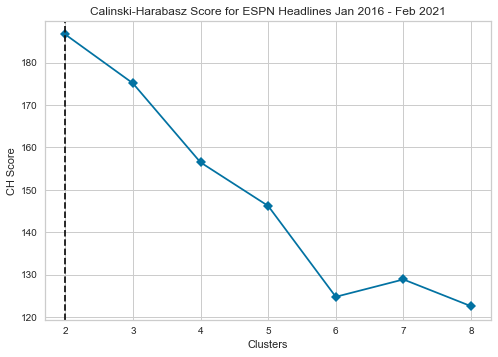

In [55]:
#check for elbow in Calinski-Harabasz score for all headlines
model = KMeans()
espn_viz = KElbowVisualizer(model, k=(2,9), metric = 'calinski_harabasz', timings=False)
espn_viz.fit(espn_df_tfidf)
plt.title('Calinski-Harabasz Score for ESPN Headlines Jan 2016 - Feb 2021')
plt.xlabel('Clusters')
plt.ylabel('CH Score')
plt.savefig('espn_total_ch_plot.png')

Calculating the Calinski-Harabasz for all the headlines combined produces a similar looking plot with the primary difference being that we have much higher scores since we have more data. It's worth noting that the clustering was performed using all of the unique tokens.  We could have much higher scores by doing PCA first and then doing the clustering. I wanted to see what clusters we might observe using all of the tokens first before doing further preprocessing of the data.

Based on teh plot above, I'll use kmeans clustering for cluster sizes 2, 3, and 4. Typically higher Calinski-Harabasz scores indicate better defined clusters. However when using Calinski-Harabasz (or any other metric) we look for the elbow in the plot and consider the number of clusters at the elbow as the optimal value. Recall from the plots of each month, there were much more "elbows" at values of 3 and 4 rather than 6, so I'll observe what the clusters look like for smaller values of k before moving to larger values of k.

In [56]:
from collections import Counter #import counter for more visualizations

### Two Clusters

In [57]:
#assign two labels to headlines using KMeans clustering
kmeans_two = KMeans(n_clusters=2, random_state=123)
kmeans_two.fit(espn_df_tfidf)
binary_classes = kmeans_two.predict(espn_df_tfidf)

In [58]:
espn_bin = espn_df
espn_bin['labels'] = binary_classes #create new column for labels

In [59]:
espn_bin.labels.value_counts() #check value counts of labels

0    31232
1     5409
Name: labels, dtype: int64

In [61]:
#preview random rows from class 0
pd.set_option('display.max_rows', None)
espn_bin.loc[espn_bin['labels'] == 0].sample(n=100, random_state=42)

headlines posted_time  \
15065                    Philadelphia All Access on ESPN  2017-12-13   
8916   Spurs' Popovich on the verge of historic miles...  2017-02-04   
33606       Pelicans can't afford loss to woeful Wizards  2020-08-07   
27493   Sources: Lakers' Cousins has serious knee injury  2019-08-15   
22824      Sources: Dirk's season debut set for Thursday  2018-12-13   
20548  Summer Forecast: Most likely first-time All-St...  2018-08-08   
14824  Bryant: Despite recent successes, everyone los...  2017-12-21   
6166   Magic rally from 18 down to top winless 76ers ...  2016-11-01   
30612  LeVert's return from thumb injury can't spark ...  2020-01-04   
18975  Playoff-eliminated Pistons look for motivation...  2018-04-05   
20219    LaVar's latest boast: In prime, I'd beat LeBron  2018-07-16   
1766   Sullinger out of hospital following skin infec...  2016-03-08   
1511     LeBron won't discuss whether he unfollowed Cavs  2016-03-22   
483    Gasol, Rose lead way as Bulls beat Celtics 101-92  2016-01-08   
18022  Westbrook's 19th triple-double of the season l...  2018-03-11   
35074  Pacers star Oladipo denies wanting out of Indiana  2020-12-01   
19846     Porter: Injury reports 'got exaggerated a lot'  2018-06-18   
2206   Q&A: After playing hoops in Israel, Nate Robin...  2016-04-19   
25369    Nets look to bolster playoff push against Hawks  2019-03-08   
24546   Ross makes 6 3s, Magic beat Timberwolves 122-112  2019-02-07   
15649  Thunder look to make it 7 straight against Pis...  2018-01-26   
11934  Rockets' Harden on acquiring Melo from Knicks:...  2017-07-14   
19116     Heat fine Whiteside for his 'detrimental' rant  2018-04-01   
4803   Leonard, Spurs spoil Kings arena opening with ...  2016-10-28   
22446   Magic's Ross fined for throwing ball into stands  2018-12-27   
25196   Report: Jazz ban 2nd fan; called Westbrook 'boy'  2019-03-15   
1875   Augustin leads Nuggets to 117-107 win over Lakers  2016-03-03   
8610      Raptors, Bulls will try to cure what ails them  2017-02-13   
32750    Pippen downplays Jordan rift after 'Last Dance'  2020-07-28   
34752  Young leads Hawks to second win, 122-112 over ...  2020-12-26   
1580   Hornets top Heat 109-106, rallying from 15-poi...  2016-03-18   
12009       Riley says Heat growth will be up to players  2017-07-10   
25508   Durant: Celtics will be fine once playoffs start  2019-03-04   
33873     Sources: Stevens met with Celtics leaders late  2020-09-18   
18864         LeBron eyes 82-game milestone for 1st time  2018-04-09   
3796    Melo planning meeting to address police violence  2016-07-22   
14090   Rockets press on without Paul, face Raptors next  2017-11-14   
23385      Clippers control second half, top Heat 111-99  2019-01-23   
16738          Fergie's national anthem confuses, amuses  2018-02-19   
33881    Adebayo sparks Heat, with assist from Spoelstra  2020-09-18   
13512        Shumpert injures foot; Cavs think he's 'OK'  2017-10-04   
12999  How a vintage Blake Griffin jam channeled Prin...  2017-10-25   
18063    Lakers sign Derrick Williams to 10-day contract  2018-03-09   
36194     Cavs on Drummond fallout: Entitled to opinions  2021-02-17   
20023    Warriors up in arms over Perkins' immobile legs  2018-06-04   
1026       Trade talk: Predicting biggest trades in West  2016-02-11   
25828  Antetokounpo leads Bucks past Pistons for 2-0 ...  2019-04-18   
34441       Source: Clippers' Morris back with $64M deal  2020-11-21   
14070          Mt Everest-like Simmons chasing 'history'  2017-11-14   
31942    Giannis reels off 40-20-5 game -- in 35 minutes  2020-03-01   
14591  Pelicans ready for Mavs, but remain in awe of ...  2017-12-28   
30600  Suns, Grizzlies meet again with eye on West st...  2020-01-05   
243    Love (17 points, 18 boards) helps Cavs bounce ...  2016-01-21   
18202  The young and surging Lakers are pushing throu...  2018-03-05   
32612  'Embarrassed' Popovich: Our country is in trouble  2020-06-07   
16937      Sour

In [62]:
#preview random rows from class 1
espn_bin.loc[espn_bin['labels'] == 1].sample(n=100, random_state=42)

headlines posted_time  \
34486  New NBA calendar: Key dates for free agency an...  2020-11-19   
17925  Fantasy NBA Daily Notes: Scouring the league f...  2018-03-14   
26305  2020 NBA mock draft: New top three prospects, ...  2019-05-28   
2885   NBA hub in Rio on tap for ticketless Olympic fans  2016-05-17   
22305                    Grading the NBA's City uniforms  2018-11-01   
13500         Aussie Bolden building NBA dream in Israel  2017-10-05   
17984  Top building blocks and fades for Monday's NBA...  2018-03-12   
2515   Why the NBA slapped the wrist of Matthew Della...  2016-04-06   
7021   By tweaking NBA calendar, league continues the...  2016-12-05   
15229  Fantasy NBA Daily Notes: Hot Suns Thursday, Fr...  2017-12-08   
32838  Inside the NBA's silent tension surrounding Da...  2020-07-20   
31648  Updated rankings for H2H points, H2H categorie...  2020-03-11   
28677  The long-awaited reaction to Carmelo Anthony's...  2019-11-15   
22831  Fantasy NBA Daily Notes: From Spencer Dinwiddi...  2018-12-13   
8877   Top fantasy basketball waiver-wire pickups at ...  2017-02-05   
33099  'It's very important we stay together': WNBA, ...  2020-08-29   
30261     Sources: NBA shelves vote on schedule overhaul  2020-01-17   
31031  NBA Power Rankings: Second-half storylines for...  2020-02-19   
32491  How NBA draft prospects are dealing with this ...  2020-06-26   
1786   Target the Bucks for 3-point help in fantasy b...  2016-03-07   
22663  Fantasy NBA Daily Notes: Larry Nance Jr. excel...  2018-12-19   
3620     NBA hires de Mello as head of NBA Latin America  2016-06-06   
4396               The 9 biggest losers of NBA offseason  2016-08-09   
17383  How Joel Embiid's injury could change the NBA ...  2018-03-30   
1066           Chalk: Complete list of Feb. 10 NBA lines  2016-02-10   
28108  Fantasy basketball specialists who can save yo...  2019-10-17   
1308        Spurs set NBA record with 38-0 start at home  2016-03-31   
36602  NBA predictions: MVP, trade deadline moves and...  2021-02-02   
33928  NBA debate: What's most underrated in the Celt...  2020-09-14   
19139       DeRozan, Embiid to play in NBA's Africa game  2018-05-31   
14608  Inside the NBA Academy and what it means for t...  2017-12-28   
13885                Rank 'em! Week 6 NBA Power Rankings  2017-11-20   
13074          Build around The Beard in NBA DFS Monday?  2017-10-23   
252    Carpenter: Eastern Conference fantasy All-Star...  2016-01-20   
25208  Fantasy NBA Daily Notes: How Paul George is ma...  2019-03-15   
12331  2017 NBA Summer Forecast: ESPN predicts the se...  2017-08-17   
19828  NBA draft trades we'd like to see: Celtics swa...  2018-06-19   
21259  The biggest questions that will shape this NBA...  2018-10-17   
5710   'The real NBA': Bogut adjusting to life outsid...  2016-11-15   
33899     NBA announces 2020 draft locked in for Nov. 18  2020-09-16   
30458  Lowe: Ten NBA things I like and don't like, in...  2020-01-10   
33699  NBA tweaks testing policy to allow quicker return  2020-08-03   
12354  Lonzo Ball tells NBA 2K they'll 'lose a custom...  2017-08-12   
24296  The top storylines to watch in the NBA's stret...  2019-02-20   
2402     Terps' Stone, Trimble decide to enter NBA draft  2016-04-12   
14768  Top stars and bargains for Friday's NBA DFS slate  2017-12-22   
15332  Rest-of-season fantasy basketball rankings for...  2017-12-05   
32168         Meet the man who motivates the NBA's stars  2020-04-08   
13569  Top building blocks and fades for Thursday's N...  2017-11-30   
65     Vote: Biggest NBA All-Star snub in each confer...  2016-01-28   
9589              Matchups matter most in NBA DFS Sunday  2017-03-12   
26791  NBA trade grades: Who wins the Hawks-Blazers d...  2019-06-24   
27652   The three superstars who defined this NBA decade  2019-09-18   
18319     NBA draft stock watch: Is Trae Young slipping?  2018-03-01   
32772   Sources: NBA looks at Williams' actions on leave  2020-07-26   
16425  What can

By previewing some of the samples in each of the two categories we can begin to see what underlying topics exist. For the '0' class we have significant majority of the headlines and there is certainly more than one topic within the cluster. We have headlines that discuss outcomes, contracts, player evaluations and a number of other things. The '1' class is much smaller and more well defined. The primary topics involved seem to be related to fantasy basketball, team/player rankings, and the NBA draft.

We'll create wordclouds and look at the top 10 words in each class to better inform our analysis.

In [63]:
espn_bin_0 = espn_bin.loc[espn_bin['labels'] == 0]
espn_bin_1 = espn_bin.loc[espn_bin['labels'] == 1]

zero_class_text = []
for element in espn_bin_0['tokens']:
    for word in element:
        zero_class_text.append(word)
        
zero_class_str = ' '.join(zero_class_text) #create string of all words from 0 class for visualization
zero_dict = Counter(zero_class_text) #count tokesn

one_class_text = []
for element in espn_bin_1['tokens']:
    for word in element:
        one_class_text.append(word)
        
one_class_str = ' '.join(one_class_text) #create string of all words from 1 class for visualization
one_class_dict = Counter(one_class_text) #count tokens
         


In [64]:
#sort most common tokens in descending order
zero_class_sorted = dict(sorted(zero_dict.items(), key= lambda item: item[1], reverse=True)) 
one_class_sorted = dict(sorted(one_class_dict.items(), key=lambda item: item[1], reverse=True))

#create dataframes for token counts
espn_bin_zero_count_df = pd.DataFrame.from_dict(zero_class_sorted, orient='index', columns=['Count'])
espn_bin_zero_count_df.reset_index(inplace=True)
espn_bin_zero_count_df.rename(columns={'index':'Word'}, inplace=True)

espn_bin_one_count_df = pd.DataFrame.from_dict(one_class_sorted, orient='index', columns=['Count'])
espn_bin_one_count_df.reset_index(inplace=True)
espn_bin_one_count_df.rename(columns={'index':'Word'}, inplace=True)


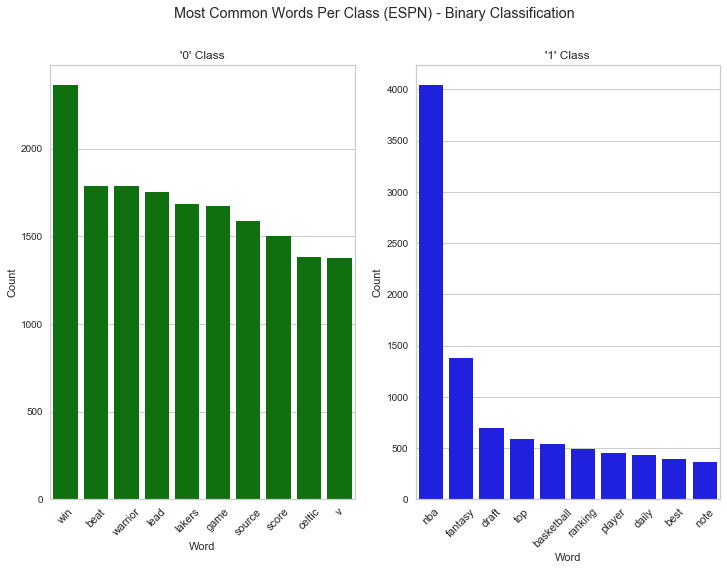

In [102]:
#plot most common words in each class
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(x=espn_bin_zero_count_df['Word'][:10], y=espn_bin_zero_count_df['Count'][:10], 
            data=espn_bin_zero_count_df[:10], ax=axs[0], color='green')
axs[0].tick_params(axis='x', labelrotation=45, labelsize=11)

sns.barplot(x=espn_bin_one_count_df['Word'][:10], y=espn_bin_one_count_df['Count'][:10], 
            data=espn_bin_one_count_df[:10], ax=axs[1], color='blue')
axs[1].tick_params(axis='x', labelrotation=45, labelsize=11)
plt.suptitle('Most Common Words Per Class (ESPN) - Binary Classification')
axs[0].set_title("'0' Class")
axs[1].set_title("'1' Class")
plt.savefig('espn_most_common_words_two_classes.png')

The most common word in group zero is win, which leads me to assume that much of group zero contains headlines that discuss the outcomes of games.  Both the words 'Lakers' and 'Warrior' also appear quite often.  2016 was the year Kobe Bryant retired from the Lakers, and LeBron James joined the Lakers in the summer of 2018. The Golden State Warriors went to the NBA Finals for 5 straight years between 2015 to 2019 so it makes sense that this term would show up frequently as well.

The samples we viewed and the 10 most common words from class 1 definitely lean towards fantasy basketball, NBA league news, and the draft. I believe that these approximately 5000 headlines constitute a well defined class and could be predicted as such by a well-trained model.

Next we will cluster the headlines with 3 groups to see if we can get more well defined groups.

### Three Clusters

In [127]:
#repeat process for clustering using 3 clusters
kmeans_three = KMeans(n_clusters=3, random_state=123)
kmeans_three.fit(espn_df_tfidf)
three_classes = kmeans_three.predict(espn_df_tfidf)

In [128]:
espn_three_df = espn_df
espn_three_df['labels'] = three_classes

In [129]:
espn_three_df['labels'].value_counts()

0    25221
1     6113
2     5307
Name: labels, dtype: int64

In [131]:
espn_three_df.loc[espn_three_df['labels'] == 0].sample(n=100, random_state=42)

headlines posted_time  \
9200            Pacers hope to get it right versus 76ers  2017-03-26   
1580   Hornets top Heat 109-106, rallying from 15-poi...  2016-03-18   
36363  AD practices, says he's being careful with Ach...  2021-02-11   
28146  Zion 'a force' in Pelicans' preseason home opener  2019-10-12   
1569   Lowry, Raptors send Celtics to fourth straight...  2016-03-19   
32747   Thunder's Noel sits scrimmage after missing test  2020-07-28   
34484    Inside the LaMelo Ball Draft Night Extravaganza  2020-11-19   
14335     Spurs' White fractures wrist, out indefinitely  2017-11-06   
9703   Buss sibling: Brothers trying to bust family t...  2017-03-08   
1028       Hornets' Kidd-Gilchrist again has torn labrum  2016-02-11   
3177   Former Louisville star recovers from brain sur...  2016-06-27   
30817       Boras to honor Kobe's wish, grant internship  2020-02-26   
21387            Clippers waive rookie forward Rodriguez  2018-10-09   
18961      Butler available but doesn't play vs. Nuggets  2018-04-06   
25776  Pacers take 'do-or-die' mindset into Game 4 vs...  2019-04-20   
29151  Magic, Bucks both coming off wins entering mat...  2019-12-28   
19822    Bucks' Brown sues city of Milwaukee over arrest  2018-06-19   
19196  Super 8: LeBron muscles his way back to the Fi...  2018-05-28   
32012       Mamba Out: Kobe also documented final season  2020-04-25   
17084  Good LeBron James trades don't really exist an...  2018-02-07   
23971                             Jazz-Cavaliers Preview  2019-01-03   
35241  Wiggins hails Warriors fit after taking it to ...  2021-01-26   
21621     Sources: Fultz's shoulder exam goes to midweek  2018-11-26   
6305          Hornets seek consistency in visit to Magic  2016-12-27   
15590        OKC's Roberson has ruptured patellar tendon  2018-01-28   
24365  Wade helps Heat top Mavs 112-101 in likely fin...  2019-02-14   
529     Slumping Wolves skip workout, stage long meeting  2016-01-05   
36068  Nets' unbeaten trip shows they've become a dif...  2021-02-22   
2682     Thompson on record 11 treys: I should've had 13  2016-05-29   
5580   Hornets, Pelicans square off after playing the...  2016-11-19   
16829      Pierce: KG's number will be retired in Boston  2018-02-14   
18742        Thunder say broadcaster's remarks offensive  2018-04-13   
10633      LeBron apologizes to Thompson for OT outburst  2017-04-03   
28097     Shaq donates home to mother of shooting victim  2019-10-18   
35741  Golden State set to play division foe Los Angeles  2021-01-07   
30057  Hield has 21 after Walton opts to start Bogdan...  2020-01-25   
11278     Sources: Mavs to decline Dirk option, eye deal  2017-06-26   
14647  Kawhi, Spurs finally healthy, will only get st...  2017-12-27   
27115    Wizards' Miles set to undergo left foot surgery  2019-07-25   
28497     Outside of Philadelphia, the Process continues  2019-11-21   
16601       Butler avoids ACL tear, has injured meniscus  2018-02-25   
8776    Harden on current Rockets: 'I love what we have'  2017-02-08   
33041  Butler pours in career-playoff-high 40 as Heat...  2020-09-01   
32069  MJ's other Bulls legacy: The 185-game streak y...  2020-04-17   
11254            Westbrook awarded MVP in landslide vote  2017-06-27   
7016              Hawks bench Korver; Sefolosha to start  2016-12-05   
12066  Best, worst rookies and vets at Utah Summer Le...  2017-07-07   
20686  No LeBron, no spotlight: Cavs start anew witho...  2018-09-24   
5748   Sixers visit NASA Johnson Space Center during ...  2016-11-13   
15035  Trail Blazers, Magic hoping to correct inconsi...  2017-12-14   
9649   Pelton mail: How many MVPs have played on aver...  2017-03-10   
36081  Toronto takes on Philadelphia, looks for 5th s...  2021-02-22   
12265  Kobe Bryant has challenges for John Wall, Gian...  2017-08-27   
20337  Lowe: Kawhi trade talk mystery, and which team...  2018-07-05   
1008       Emojis become part of act on All-Star Weekend  2016-02-12   
11938     CP3 o

In [132]:
espn_three_df.loc[espn_three_df['labels'] == 1].sample(n=100, random_state=42)

headlines posted_time  \
24486  Bogdanovic leads Pacers past Cavaliers for 5th...  2019-02-09   
1236   Kobe scores 38, Lakers beat Wolves 119-115 to ...  2016-02-03   
17675  LeBron scores 35, carries Cavaliers past Rapto...  2018-03-21   
35812  Gordon helps Magic beat Cavaliers 103-83, snap...  2021-01-04   
26237  Horford logs first triple-double as a Celtic i...  2019-04-02   
2097   Hornets drop Heat for 1st playoff win in 14 years  2016-04-23   
22698   George, Westbrook lead Thunder past Bulls 121-96  2018-12-18   
23346  Westbrook's 15th triple-double leads Thunder p...  2019-01-25   
22669  Lin's big 4th quarter leads Hawks past Wizards...  2018-12-18   
2161   Clippers dominate 4th to beat Blazers 102-81, ...  2016-04-21   
9770   Bogdanovic hits 8 3-pointers, Wizards beat Mag...  2017-03-05   
4995   United fall short as Wildcats win fourth straight  2016-10-23   
21072  Cavaliers still looking for first win as they ...  2018-10-23   
28938  Graham, Biyombo lift Hornets past Pacers 122-1...  2019-11-05   
36125  Nets take on the Clippers, aim for 6th straigh...  2021-02-20   
29996  Thunder put five-game win streak on line again...  2020-01-27   
29727  Brown scores 31 points in Celtics 112-93 victo...  2019-12-05   
754    Hayward scores 28 as Jazz defeat Rockets 117-1...  2016-02-24   
9173    Turner leads Pacers to 107-94 victory over 76ers  2017-03-27   
548    Heat rally from 18 down, top Pacers 103-100 in OT  2016-01-05   
31901  Brogdon scores 26, Pacers forced to rally late...  2020-03-03   
17249  Davis' 43 points lead Pelicans past Thunder 11...  2018-02-03   
22255  Curry, Durant lead the way in Warriors' 7th st...  2018-11-03   
31112  Clarke lead Grizzlies to a 111-104 win over Tr...  2020-02-13   
29706  Will Barton scores 17 points, Nuggets beat Kni...  2019-12-05   
23185  Beal, Green lead Wizards past reeling Pacers 1...  2019-01-30   
19621  James has triple-double, Cavs beat Raptors in ...  2018-05-02   
34805  Hield tip-in leads Kings to 124-122 overtime w...  2020-12-24   
28517    Allen leads Nets to 101-91 victory over Hornets  2019-11-20   
23461  Antetokounmpo has 31 points as Bucks beat Mave...  2019-01-21   
15180  James Harden scores 48 points, Rockets win 9th...  2017-12-10   
15939  Evans has 23 points, 10 assists as Grizzlies b...  2018-01-18   
27940  Irving helps Nets beat Knicks 113-109 after bl...  2019-10-25   
7494   Williams, Young lead Lakers to 108-96 win over...  2017-01-21   
9591    Davis posts 46-21 as Pels sit Boogie late in win  2017-03-12   
20970      Bulls visit Hawks in search of first road win  2018-10-27   
30010           Leonard leads Clippers to win over Magic  2020-01-26   
10013  Powell scores 25 as Raptors beat Bucks 118-93 ...  2017-04-25   
7269     All-Star Hayward to lead Jazz against Grizzlies  2017-01-28   
22628       Rockets ride five-game win streak into Miami  2018-12-20   
22962  Doncic scores 11 straight, Mavs rally past Roc...  2018-12-08   
14237      Kings look to end 76ers' five-game win streak  2017-11-09   
25787  Celtics beat Pacers 104-96 to take 3-0 series ...  2019-04-20   
22401         Murray helps Nuggets hold off Spurs 102-99  2018-12-29   
5614   Butler scores 20 as Bulls beat Jazz 85-77 on t...  2016-11-18   
30320   Harris scores 34, leads Sixers past Nets 117-106  2020-01-15   
6719   Jackson, Drummond lead Pistons over last-place...  2016-12-15   
22120  Mitchell returns, Jazz end skid with win vs Ma...  2018-11-08   
9288   Mirotic scores season-high 28, Bulls beat Pist...  2017-03-22   
36083  Antetokounmpo, Middleton lead Bucks past Kings...  2021-02-22   
35854  Sexton, Drummond pace Cavs' rally in win over ...  2021-01-02   
18906  Westbrook and George help Thunder over Rockets...  2018-04-08   
6637   Rockets make NBA-record 24 3-pointers, beat Pe...  2016-12-17   
22584        Markkanen scores 32, Bulls beat Magic 90-80  2018-12-22   
17395         Nuggets face must-win scenario vs. Thunder  2018-03-30   
22387  Giannis'

In [133]:
espn_three_df.loc[espn_three_df['labels'] == 2].sample(n=100, random_state=42)

headlines posted_time  \
6312   Fantasy basketball Top 150: Zach LaVine soars ...  2016-12-27   
35981  How will the NBA's compressed second-half sche...  2021-02-25   
13911  Top stars and bargains for Sunday's NBA DFS slate  2017-11-19   
9244           FSU freshman Isaac declares for NBA draft  2017-03-24   
21026  Fantasy NBA Daily Notes: Kawhi has returned to...  2018-10-25   
11054  Lonzo Ball or Markelle Fultz: Who should be No...  2017-05-06   
34213  Are LeBron's four NBA titles better than Jorda...  2020-10-13   
19679  Why NBA teams can get good free agents at low ...  2018-06-29   
19361  FAQ: How will legal gambling change the NBA an...  2018-05-17   
14199  Top stars and bargains for Friday's NBA DFS slate  2017-11-10   
16155  The NBA is in London, so why no UK stars in th...  2018-01-11   
12507        Fantasy basketball: Top faces in new places  2017-09-27   
14139  Top stars and bargains for Sunday's NBA DFS slate  2017-11-12   
18102  Top stars and bargains for Thursday's NBA DFS ...  2018-03-08   
1859   Kaiser: Top impact fantasy rookies for next se...  2016-03-03   
15835          Top NBA DFS stars and bargains for Sunday  2018-01-21   
30822  Wednesday's NBA best bets: Slumping Jazz rebou...  2020-02-26   
19723        No more debate: Simmons is NBA's top rookie  2018-06-26   
36604     NBA mock draft: New projections for picks 1-60  2021-02-02   
33846   Silver: Best guess next NBA season starts in '21  2020-09-22   
11794  Scouting best draft prospects at U20 European ...  2017-07-27   
28981     NBA names DraftKings official betting operator  2019-11-04   
742       Whiteside rises in fantasy basketball rankings  2016-02-24   
13110      Overall stat projections for every NBA player  2017-10-22   
17146  NBA player rankings: Stellar PG play from Rubi...  2018-02-06   
14936  Top stars and bargains for Sunday's NBA DFS slate  2017-12-17   
3508   How the NBA draft lottery impacts fantasy pros...  2016-06-13   
19808  NBA draft: Best prospects, likely picks, ranki...  2018-06-21   
5260   Porzingis and Towns, just two friends redefini...  2016-11-30   
32227     Sources: NBA, NBPA talk withholding player pay  2020-04-01   
12628         Check out the NBA's new alternate uniforms  2017-09-20   
17662       Arizona's Ayton says he will enter NBA draft  2018-03-22   
35793  Fantasy basketball mock draft: 8-team, head-to...  2021-01-05   
9851   Pelton mail: Who is the best NBA buyout pickup...  2017-03-03   
4429                            NBA players ... as sushi  2016-08-03   
3467   Draymond says he's not 'He-Man,' but Kerr call...  2016-06-16   
19624   Lowe: First look at the NBA's new virtual courts  2018-05-02   
13188  Will the Wolves finally break the NBA's unluck...  2017-10-20   
4762   NBA Power Rankings: Warriors looking up at the...  2016-10-29   
5409              What I'm thankful for in fantasy hoops  2016-11-25   
28563  Fantasy basketball: Why now is the time to tra...  2019-11-19   
5757   Daily fantasy basketball - Which stars to use ...  2016-11-13   
4154   NFL players post strong reactions to NBA playe...  2016-07-03   
11882  NBA's Silver thinks legalized betting will happen  2017-07-19   
1374     LSU's Quarterman to enter NBA draft, Jones says  2016-03-28   
32063  Silver: NBA not in position to make any decisions  2020-04-17   
65     Vote: Biggest NBA All-Star snub in each confer...  2016-01-28   
8040   Fantasy Basketball Top 150: Antetokounmpo jump...  2017-01-04   
4412               Nine biggest winners of NBA offseason  2016-08-07   
5531          Top fantasy basketball waiver-wire pickups  2016-11-20   
36357  Why Payton Pritchard is the most important pla...  2021-02-12   
13444  Breaking down NBA moves and injuries, includin...  2017-10-10   
13703  Joe Ingles among top fantasy basketball free-a...  2017-11-26   
23445           Fantasy NBA Daily Notes: Klay's hot hand  2019-01-22   
11251  Taylor Swift congratulates Russell Westbrook f...  2017-06-27   
13885          

By clustering the headlines into 3 groups, the topics within each cluster are more well defined. There is still a class imbalance with group zero having approximately 25,000 of the 36,000 headlines. Group zero still seems to contain a wide variety of topics. Group one seems to contain mostly game scores/outcomes, and group two contains headlines mostly concerning the NBA Draft and fantasy basketball.

In [74]:
#create strings of tokens for each of the three classes
espn_tri_zero = espn_three_df.loc[espn_three_df['labels'] == 0]
espn_tri_one = espn_three_df.loc[espn_three_df['labels'] == 1]
espn_tri_two = espn_three_df.loc[espn_three_df['labels'] == 2]

tri_zero_class_text = []
for element in espn_tri_zero['tokens']:
    for word in element:
        tri_zero_class_text.append(word)
        
tri_zero_class_str = ' '.join(tri_zero_class_text)
tri_zero_dict = Counter(tri_zero_class_text)

tri_one_class_text = []
for element in espn_tri_one['tokens']:
    for word in element:
        tri_one_class_text.append(word)
        
tri_one_class_str = ' '.join(tri_one_class_text)
tri_one_class_dict = Counter(tri_one_class_text)

tri_two_class_text = []
for element in espn_tri_two['tokens']:
    for word in element:
        tri_two_class_text.append(word)
        
tri_two_class_str = ' '.join(tri_two_class_text)
tri_two_class_dict = Counter(tri_two_class_text)



In [76]:
#sort dictionaries in descending order
tri_zero_sorted = dict(sorted(tri_zero_dict.items(), key=lambda item: item[1], reverse=True)) 
tri_one_sorted = dict(sorted(tri_one_class_dict.items(), key=lambda item: item[1], reverse=True))
tri_two_sorted = dict(sorted(tri_two_class_dict.items(), key=lambda item: item[1], reverse=True))

espn_tri_zero_df = pd.DataFrame.from_dict(tri_zero_sorted, orient='index', columns=['Count'])
espn_tri_zero_df.reset_index(inplace=True)
espn_tri_zero_df.rename(columns={'index':'Word'}, inplace=True)

espn_tri_one_df = pd.DataFrame.from_dict(tri_one_sorted, orient='index', columns=['Count'])
espn_tri_one_df.reset_index(inplace=True)
espn_tri_one_df.rename(columns={'index':'Word'}, inplace=True)

espn_tri_two_df = pd.DataFrame.from_dict(tri_two_sorted, orient='index', columns=['Count'])
espn_tri_two_df.reset_index(inplace=True)
espn_tri_two_df.rename(columns={'index':'Word'}, inplace=True)



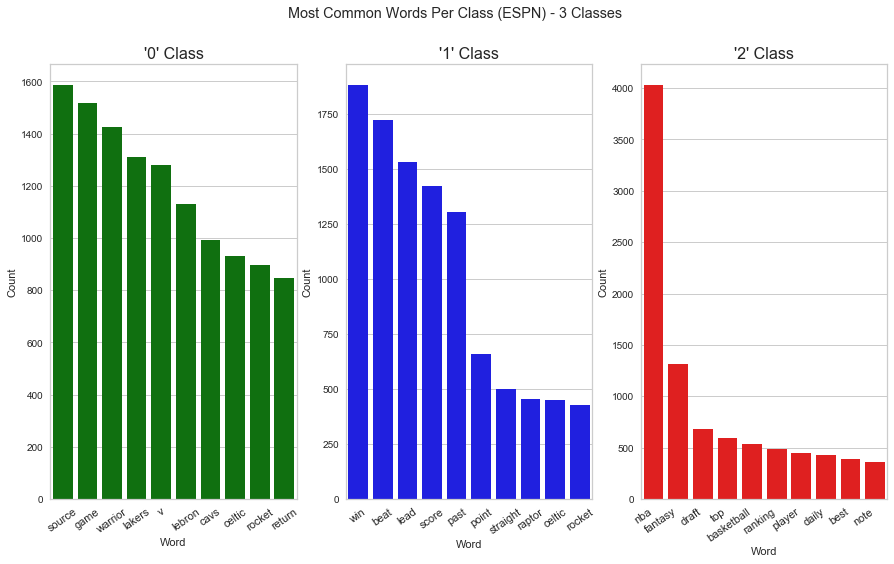

In [101]:
#view most common words for 3 classes
import seaborn as sns
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
sns.barplot(x=espn_tri_zero_df['Word'][:10], y=espn_tri_zero_df['Count'][:10], 
            data=espn_tri_zero_df[:10], ax=axs[0], color='green')
axs[0].tick_params(axis='x', labelrotation=35, labelsize=11)

sns.barplot(x=espn_tri_one_df['Word'][:10], y=espn_tri_one_df['Count'][:10], 
            data=espn_tri_one_df[:10], ax=axs[1], color='blue')
axs[1].tick_params(axis='x', labelrotation=35, labelsize=11)

sns.barplot(x=espn_tri_two_df['Word'][:10], y=espn_tri_two_df['Count'][:10], 
            data=espn_tri_two_df[:10], ax=axs[2], color='red')
axs[2].tick_params(axis='x', labelrotation=35, labelsize=11)

plt.suptitle('Most Common Words Per Class (ESPN) - 3 Classes')
axs[0].set_title("'0' Class", fontsize=16)
axs[1].set_title("'1' Class", fontsize=16)
axs[2].set_title("'2' Class", fontsize=16)
plt.xticks(horizontalalignment='right')
plt.savefig('espn_most_common_words_three_classes.png')

In [ ]:
# 0 class - Game Previews/Player Profiles/"Sources Say"/Injuries
# 1 class - Game score and event outcomes
# 2 class - draft/fantasy/speculative/evaluation

In [115]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

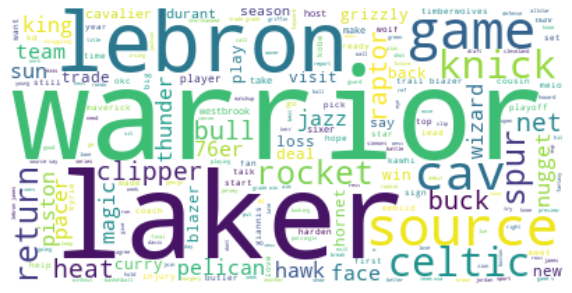

In [141]:
#create word cloud for group 0
wc_tri_class_zero = WordCloud(background_color='white')
wc_tri_class_zero.generate(tri_zero_class_str)

plt.figure(figsize=(10,10))
plt.imshow(wc_tri_class_zero, interpolation='bilinear')
plt.axis('off')
plt.show()
wc_tri_class_zero.to_file('group_zero_wordcloud.png')

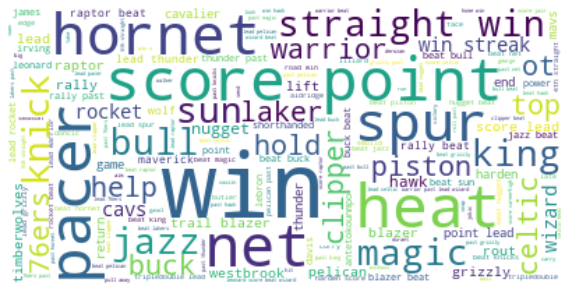

In [142]:
#create word cloud for group one
wc_tri_class_one = WordCloud(background_color='white')
wc_tri_class_one.generate(tri_one_class_str)

plt.figure(figsize=(10,10))
plt.imshow(wc_tri_class_one, interpolation='bilinear')
plt.axis('off')
plt.show()
wc_tri_class_one.to_file('group_one_wordcloud.png')

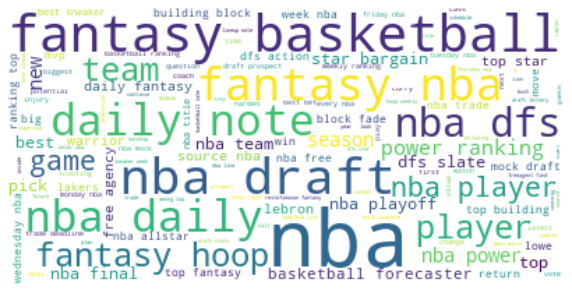

In [143]:
#create word cloud for group 2
wc_tri_class_two = WordCloud(background_color='white')
wc_tri_class_two.generate(tri_two_class_str)

plt.figure(figsize=(10, 10))
plt.imshow(wc_tri_class_two, interpolation='bilinear')
plt.axis('off')
plt.show()
wc_tri_class_two.to_file('group_two_wordcloud.png')

Both the bar charts for the most common words and the wordclouds confirm what we saw in the previews of each cluster.  Group zero is a bit of a mixed bag in terms of topics but it seems to contain topics that are both team-foucsed and player-focused along with player movements (i.e. free agency/trades). Group one is focused most on game scores and outcomes. There are approximately 6000 headlines in this category and there are 1230 games in a full NBA season (which would amount to 6,150 for five full seasons), so the number of headlines in this cluster matches well with our descriptions.  Group two is all about the draft and daily fantasy projections (similar to the smaller cluster when we set k to be 2).

### Checking Word Length Distributions

In [135]:
def count_length(text):
    "This function counts the words in each headline."
    words = "".join([word for word in text if word not in string.punctuation])
    return len(words.split())

In [136]:
espn_three_df['word_length'] = espn_three_df['headlines'].apply(count_length)
espn_three_df.head()

headlines posted_time  \
0  Wade matches King for 42nd on scoring list in win  2016-02-01   
1  McCollum, Lillard lead Blazers past Timberwolv...  2016-02-01   
2  Heat win season-best 4th straight, top Hawks 1...  2016-02-01   
3  Williams helps Mavs win without Nowitzki, 91-7...  2016-01-31   
4       Chick Hearn's widow, Marge Hearn, dies at 98  2016-01-31   

                                              tokens  labels  word_length  
0      [wade, match, king, 42nd, scoring, list, win]       0           10  
1  [mccollum, lillard, lead, blazer, past, timber...       1            7  
2  [heat, win, seasonbest, 4th, straight, top, ha...       1            8  
3  [williams, help, mavs, win, without, nowitzki,...       1            9  
4       [chick, hearns, widow, marge, hearn, dy, 98]       0            8

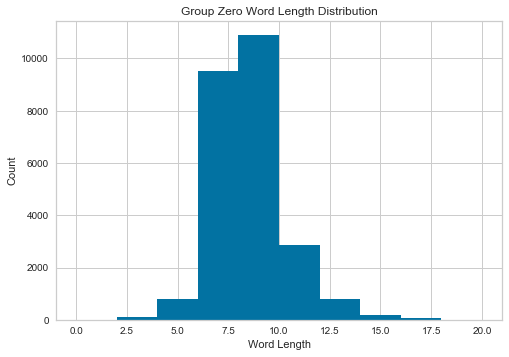

In [145]:
#create distribution of word length for group zero
espn_three_df.loc[espn_three_df['labels'] == 0]['word_length'].hist()
plt.title('Group Zero Word Length Distribution')
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.savefig('espn_zero_word_count_hist.png')

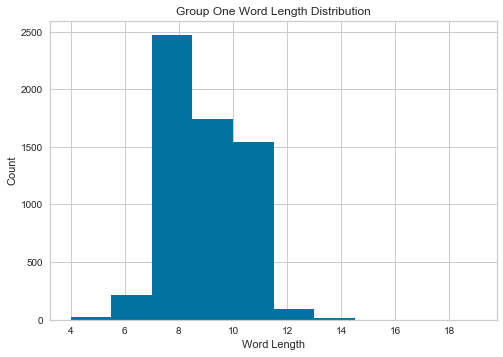

In [146]:
#create distribution of word length for group one
espn_three_df.loc[espn_three_df['labels'] == 1]['word_length'].hist()
plt.title('Group One Word Length Distribution')
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.savefig('espn_one_word_count_hist.png')

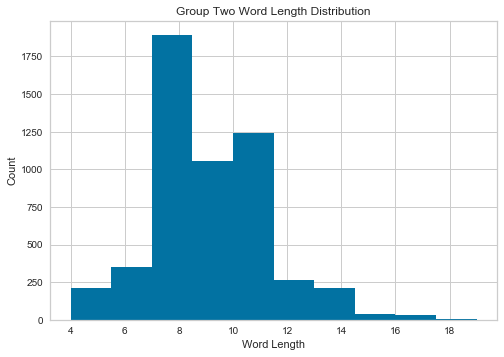

In [147]:
#create distribution of word length for group two
espn_three_df.loc[espn_three_df['labels'] == 2]['word_length'].hist()
plt.title('Group Two Word Length Distribution')
plt.xlabel('Word Length')
plt.ylabel('Count')
plt.savefig('espn_two_word_count_hist.png')

There appears to be no distinctive differences in the word length of each cluster. They all appear to be fairly normal and the center of the distribution falls somewhere between 7.5 and 10 words. The length of the headline does not seem like it would be a good indicator for classifying the topic.

To recap, the primary topics found when k=3 are:
    
- Group Zero: Mixed Bag of Topics
- Group One: Game Scores/Outcomes
- Group Two: Daily Fantasy and Rankings


**Player and Team Counts**

**The below functions and cells are meant to count player and team mentions. I will do exploratory data analysis for players and teams in a separate notebook.**

In [193]:
def count_player_mentions(text):
    
    """This function counts the number of times a player has been mentioned in a specific headline. The function
    can be modified to include more or less players. The input of the function should be a string. The function
    will return a list with the count for the respective players."""
    
    text_string = text
    
    lebron_count = 0
    curry_count = 0
    harden_count = 0
    kd_count = 0
    kyrie_count = 0
    dame_count = 0
    luka_count = 0
    zion_count = 0
    ja_count = 0
    giannis_count = 0
    
    if text_string.count('LeBron') > 0 or text_string.count('LBJ') > 0 or text_string.count('King James') > 0:
        lebron_count += 1
    
    if text_string.count('Curry') > 0 or text_string.count('Stephen') > 0 or text_string.count('Steph') > 0:
        curry_count += 1
    
    if text_string.count('James Harden') > 0 or text_string.count('Harden') > 0:
        harden_count += 1
        
    if text_string.count('Kevin Durant') > 0 or text_string.count('Durant') > 0 or text_string.count('KD') > 0:
        kd_count += 1
        
    if text_string.count('Kyrie Irving') > 0 or text_string.count('Irving') > 0 or text_string.count('Kyrie') > 0:
        kyrie_count += 1
        
    if text_string.count('Damian Lillard') > 0 or text_string.count('Lillard') > 0 or text_string.count('Dame') > 0:
        dame_count += 1
    
    if text_string.count('Luka Doncic') > 0 or text_string.count('Luka') > 0 or text_string.count('Doncic') > 0:
        luka_count += 1
        
    if text_string.count('Zion Williamson') > 0 or text_string.count('Williamson') > 0 or text_string.count('Zion') >0:
        zion_count += 1
        
    if text_string.count('Ja Morant') > 0 or text_string.count('Morant') > 0 or text_string.count('Ja '):
        ja_count += 1
        
    if text_string.count('Giannis') > 0 or text_string.count('Antetokounmpo') > 0 or text_string.count('Greek Freak') > 0:
        giannis_count += 1
        
    return [lebron_count, curry_count, harden_count, kd_count, 
            kyrie_count, dame_count, luka_count, zion_count, ja_count, giannis_count]
        
        
        
        
    
    

In [199]:
def team_mentions_count(text):
    
    """This function counts the number of times a team has been mentioned in a specific headline. 
    The input of the function should be a string. The function will return a list with the count for the 
    respective teams."""
    
    text_str = text
    
    atl_count = 0
    boston_count = 0
    brooklyn_count = 0
    charlotte_count = 0
    chicago_count = 0
    cleveland_count = 0
    dallas_count = 0
    denver_count = 0
    detroit_count = 0
    gsw_count = 0
    houston_count = 0
    indiana_count = 0
    clippers_count = 0
    lakers_count = 0
    memphis_count = 0
    miami_count = 0
    bucks_count = 0
    minn_count = 0
    pelicans_count = 0
    knicks_count = 0
    okc_count = 0
    orlando_count = 0
    philly_count = 0
    phoenix_count = 0
    portland_count = 0
    sac_count = 0
    spurs_count = 0
    raptors_count = 0
    utah_count = 0
    wizards_count = 0
    
    if text_str.count('Atlanta') > 0 or text_str.count('ATL') > 0 or text_str.count('Hawks') > 0:
        atl_count += 1
        
    if text_str.count('Boston') > 0 or text_str.count('Celtics') > 0:
        boston_count += 1
        
    if text_str.count('Brooklyn') > 0 or text_str.count('Nets') > 0:
        brooklyn_count += 1
        
    if text_str.count('Charlotte') > 0 or text_str.count('Hornets') > 0:
        charlotte_count += 1
        
    if text_str.count('Chicago') > 0 or text_str.count('Bulls') > 0 or text_str.count('Windy City') > 0:
        chicago_count += 1
        
    if text_str.count('Cleveland') > 0 or text_str.count('Cavaliers') > 0 or text_str.count('Cavs') > 0:
        cleveland_count += 1
        
    if text_str.count('Dallas') > 0 or text_str.count('Mavericks') > 0 or text_str.count('Mavs') > 0:
        dallas_count += 1
        
    if text_str.count('Denver') > 0 or text_str.count('Nuggets') > 0:
        denver_count += 1
        
    if text_str.count('Detroit') > 0 or text_str.count('Pistons') > 0 or text_str.count('Motor City') > 0:
        detroit_count += 1
        
    if text_str.count('Golden State') > 0 or text_str.count('Warriors') > 0 or text_str.count('GSW') > 0:
        gsw_count += 1
        
    if text_str.count('Houston') > 0 or text_str.count('Rockets') > 0 or text_str.count('H-Town') > 0:
        houston_count += 1
        
    if text_str.count('Indiana') > 0 or text_str.count('Pacers') > 0:
        indiana_count += 1
        
    if text_str.count('Clippers') > 0 or text_str.count('LAC') > 0 or text_str.count('Clips') > 0:
        clippers_count += 1
        
    if text_str.count('Lakers') > 0 or text_str.count('LAL') > 0:
        lakers_count += 1
        
    if text_str.count('Memphis') > 0 or text_str.count('Grizzlies') > 0:
        memphis_count += 1
        
    if text_str.count('Miami') > 0 or text_str.count('Heat') > 0:
        miami_count += 1
        
    if text_str.count('Milwaukee') > 0 or text_str.count('Bucks') > 0:
        bucks_count += 1
        
    if text_str.count('New Orleans') > 0 or text_str.count('Pelicans') > 0 or text_str.count('NOP') > 0:
        pelicans_count += 1
        
    if text_str.count('NYK') > 0 or text_str.count('Knicks') > 0 or text_str.count('New York') > 0:
        knicks_count += 1
        
    if text_str.count('OKC') > 0 or text_str.count('Thunder') > 0 or text_str.count('Oklahoma City Thunder') > 0:
        okc_count += 1
        
    if text_str.count('Orlando') > 0 or text_str.count('Magic') > 0:
        orlando_count += 1
        
    if text_str.count('Philadelphia') > 0 or text_str.count('76ers') > 0 or text_str.count('Sixers') > 0 or text_str.count('Philly') > 0:
        philly_count += 1
        
    if text_str.count('Phoenix') > 0 or text_str.count('Suns') > 0:
        phoenix_count += 1
        
    if text_str.count('Portland') > 0 or text_str.count('Trailblazers') > 0 or text_str.count('Blazers'):
        portland_count += 1
        
    if text_str.count('Sacramento') > 0 or text_str.count('Kings') > 0:
        sac_count += 1
        
    if text_str.count('San Antonio') > 0 or text_str.count('Spurs') > 0:
        spurs_count += 1
        
    if text_str.count('Toronto') > 0 or text_str.count('Raptors') > 0 or text_str.count('Jurassic Park') > 0:
        raptors_count += 1
        
    if text_str.count('Utah') > 0 or text_str.count('Jazz') > 0 or text_str.count('Salt Lake City') > 0:
        utah_count += 1
        
    if text_str.count('Washington') > 0 or text_str.count('Wizards') > 0 or text_str.count('DC') > 0:
        wizards_count += 1
        
    return [atl_count, boston_count, brooklyn_count, charlotte_count , chicago_count, cleveland_count,
            dallas_count, denver_count, detroit_count, gsw_count, houston_count, indiana_count,
            clippers_count, lakers_count, memphis_count, miami_count, bucks_count, minn_count, pelicans_count,
            knicks_count, okc_count, orlando_count, philly_count, phoenix_count, portland_count, sac_count,
            spurs_count, raptors_count, utah_count, wizards_count]
     
    
    

In [190]:
espn_headlines_list = list(espn_three_df['headlines'])

In [194]:
#store player counts in a variable
player_mentions_count = [count_player_mentions(title) for title in espn_headlines_list]


In [202]:
#convert player mentions to a dataframe
player_mentions_df = pd.DataFrame(player_mentions_count, columns=['Lebron', 'Steph', 'Harden', 'KD', 'Kyrie',
                                                                  'Dame','Luka','Zion','Ja','Giannis'])

In [200]:
#store team counts in a variable
team_mention_count = [team_mentions_count(title) for title in espn_headlines_list]

In [204]:
#create team mentions dataframe
team_mentions_df = pd.DataFrame(team_mention_count, columns=['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL',
            'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC',
            'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAT', 'TOR', 'UTAH', 'WAS'])

In [226]:
#save dataframes
espn_three_df.to_csv('espn_three_classes.csv', index=False)
espn_df_tfidf.to_csv('espn_tfidf.csv', index=False)
player_mentions_df.to_csv('player_mentions.csv', index=False)
team_mentions_df.to_csv('team_mentions.csv', index=False)

## Reclustering within Group Zero

Since group zero contained most of the headlines, it is worth performing kmeans clustering on that group alone to see if we can define clusters within clusters. It makes sense to try and tackle this approach with a top-down approach because as we increase the number of overall clusters we run the risk of reducing the effectiveness of a classification model. More classes means that we're going to have a smaller number of samples in each class which means less training examples once the data is split between training and test sets. We would also need to think about how similar or different certain subclusters might be to each other and whether those differences could be discerned by a model.

In [206]:
#create tfidf dataframe for group zero headlines
group_zero_tfidf = tfidf_vectorizer(espn_tri_zero)

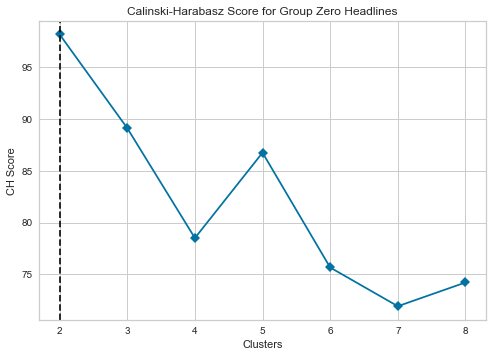

In [208]:
#check kmeans clustering within group zero headlines
kmeans_grp_zero = KMeans()
espn_grp_zero = KElbowVisualizer(kmeans_grp_zero, k=(2,9), metric = 'calinski_harabasz', timings=False)
espn_grp_zero.fit(group_zero_tfidf)
plt.title('Calinski-Harabasz Score for Group Zero Headlines')
plt.xlabel('Clusters')
plt.ylabel('CH Score')
plt.savefig('group_zero_clustering.png')

For the subclustering, I will create clusters using k=2 and k=3. There's not a clear elbow from the plot above, but as previously mentioned, a higher score is a better defined cluster. We also want to make sure that we don't get to granular and end up having a cluster that has too few examples.

In [209]:
#create labels for two subclusters
kmeans_grp_zero_two = KMeans(n_clusters=2, random_state=123)
kmeans_grp_zero_two.fit(group_zero_tfidf)
secondary_classes_two = kmeans_grp_zero_two.predict(group_zero_tfidf)

In [210]:
espn_tri_zero['secondary_labels'] = secondary_classes_two

/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [214]:
#check value counts when using 2 sublcusters
espn_tri_zero['secondary_labels'].value_counts()

0    23413
1     1808
Name: secondary_labels, dtype: int64

In [212]:
espn_tri_zero.loc[espn_tri_zero['secondary_labels'] == 0].sample(n=100, random_state=42)

headlines posted_time  \
5807       Mavs, ESPN resolve dispute over team coverage  2016-11-11   
25635  Whatever it takes: Joel Embiid's quest for gre...  2019-04-29   
20493   Kuzma: Critics 'underestimating' new-look Lakers  2018-08-15   
36267    Source: Lakers' Davis aggravates Achilles issue  2021-02-15   
26265    D'Antoni breaks off contract talks with Rockets  2019-05-31   
9721   Timberwolves return to court after Monday's po...  2017-03-07   
27777         Pacers' Turner (ankle sprain) week-to-week  2019-10-31   
8025   Bogut: 'Hanging around' with Mavericks not likely  2017-01-05   
32347        L.A.'s popular Drew League cancels schedule  2020-05-14   
11637     Silver expects rest guidelines for next season  2017-06-09   
7524         Anunoby still a lottery pick after surgery?  2017-01-20   
12192  Lowe: OKC gambles on Paul George and wins a trade  2017-07-01   
15075      Wizards' Wall back from knee injury Wednesday  2017-12-13   
22563        Pistons look to go above .500 against Hawks  2018-12-22   
4281   With All-Star Game's arrival, will Anthony Dav...  2016-08-21   
10961  Zach Lowe: Big things (and little things) to w...  2017-05-12   
22595  CP3 to miss at least 2 weeks for hamstring injury  2018-12-21   
24000      Knicks' Kanter meets with GM over lesser role  2019-01-02   
12305            Lonzo Ball thanks Jay-Z for buying ZO2s  2017-08-21   
8578   Magic: If in charge of Lakers, I want Kobe's help  2017-02-14   
10781      Center Speights declines option with Clippers  2017-05-23   
27703     Team USA's Tatum game-time decision vs. France  2019-09-11   
23999         Nets' Crabbe (knee) to miss 1-2 more weeks  2019-01-02   
1699    U.S. men's basketball to open Olympics vs. China  2016-03-11   
23573  Thunder's Noel set to play after clearing prot...  2019-01-17   
377         Pneumonia ends Clips C Jordan's games streak  2016-01-14   
27232        Lamar Odom among four 'deactivated' by Big3  2019-07-11   
21295      Heavily favored Warriors scaring bettors away  2018-10-16   
11345       Vote: What's your grade for the Suns' draft?  2017-06-23   
25845  Jazz make adjustments ahead of Game 2 vs. Rockets  2019-04-17   
11856              Kevin Love is fine, thanks for asking  2017-07-21   
25166  House ready for more as Rockets host Timberwolves  2019-03-16   
34884  Wizards tip off season at home against the Pis...  2020-12-19   
34319     Hawks' Pierce continues social justice efforts  2020-10-01   
13199       Nets begin life without Lin by hosting Magic  2017-10-20   
4397                       DeMarcus Cousins ... gymnast?  2016-08-09   
30854  Clips fire on all cylinders with return to ful...  2020-02-25   
28926       Bucks visit Clippers in battle of superstars  2019-11-06   
14935  Winslow due to return for injury-riddled Heat ...  2017-12-17   
6441              Nuggets play host to Howard-less Hawks  2016-12-22   
10468  Clippers have more at stake than Spurs in Satu...  2017-04-08   
30504  Knicks' Portis fined $25K for swipe at KCP's head  2020-01-08   
29793  Spurs try to halt slump against Harden-led Roc...  2019-12-02   
23453  Balanced Pelicans easily top Grizzlies without...  2019-01-21   
17392  Kevin Durant ejected in return as Bucks rout W...  2018-03-30   
1711         Okafor knee soreness could be season ending  2016-03-11   
19508  'The Other Cavaliers' take the stage in unaire...  2018-05-08   
28616      Spurs bring five-game losing streak to Dallas  2019-11-17   
648         LeBron given day off as Cavs play at Wizards  2016-02-28   
31514    Source: Pistons'  Wood cleared from coronavirus  2020-03-26   
23328  Pelicans without Davis, Mirotic for matchup wi...  2019-01-25   
19588      Raptors struggling to overcome Cavs ... again  2018-05-03   
36055       Boston plays Dallas, looks to end road slide  2021-02-23   
22462  Jazz aim to keep winning with defense against ...  2018-12-27   
35402  Grizzlies-Blazers postponed due to contact tra...  2021-01-20   
4589   Will Wes

In [213]:
espn_tri_zero.loc[espn_tri_zero['secondary_labels'] == 1].sample(n=100, random_state=42)

headlines posted_time  \
31724    Sources: Giannis gets precautionary MRI on knee  2020-03-08   
1998    Sources: Kings poised to lure Pistons' Catanella  2016-04-27   
12284      Sources: OKC's Winger agrees to Clips' GM job  2017-08-24   
19061     Sources: Silver to reveal 1st pick at 2K draft  2018-04-03   
32001  Bulls tap 76ers' Eversley for GM job, sources say  2020-04-27   
15038       Sources: Rockets' Mbah a Moute out 2-3 weeks  2017-12-14   
8382       Cavaliers' Williams signed to 2nd 10-day deal  2017-02-22   
34439  Trade grades: Who wins the Mavs-Thunder-Piston...  2020-11-21   
8332        Sources: Suns gets Scott from Hawks for cash  2017-02-23   
11328  Trade grades: Which team flunked the Jimmy But...  2017-06-23   
6505      Cavs fear Smith broke right thumb, sources say  2016-12-21   
24553     Mirotic headed to Bucks as part of 3-team deal  2019-02-07   
11202     Sources: Knicks' focus on free agency, for now  2017-06-29   
3784   Warriors' Green to avoid jail time with plea deal  2016-07-22   
10765       Sources: Bosh, Heat to part after resolution  2017-05-24   
34864       Sources: Heat end pursuit of Rockets' Harden  2020-12-21   
19877          Sources: Pacers' Young may join FA market  2018-06-14   
16884     Sources: Wizards considering signing T. Lawson  2018-02-12   
20110      Sources: Hawks add Vince Carter for 21st year  2018-07-25   
34422  Source: Magic keep Clark in fold with 2-year deal  2020-11-21   
3203   Sources: Cavs' Irving fills out U.S. roster fo...  2016-06-26   
21318  Trade grades: Who wins the Clippers-Pelicans d...  2018-10-15   
12057      Sources: Pistons' Caldwell-Pope to become UFA  2017-07-07   
19018        Sources: Warriors working on deal with Cook  2018-04-04   
4242    Sources: Spurs pursuing Argentina's Laprovittola  2016-08-26   
34778  Sources: Zeller likely out 4-6 weeks after sur...  2020-12-24   
18197          Sources: Hornets expand GM candidate pool  2018-03-05   
27281     Sources: Rockets 'long shot' to grab Westbrook  2019-07-08   
27398         Sources: Rockets, Gordon reach $54.5M deal  2019-08-31   
22184   Cavs reach deal for Drew to coach rest of season  2018-11-05   
22817    Sources: Trier gets $7M deal in Knicks contract  2018-12-13   
20308      Sources: Lopez reaches 1-year deal with Bucks  2018-07-08   
31036    Jones Jr. gets Puma deal after dunk contest win  2020-02-17   
8337            Trade grades: Who wins Hawks-Suns trade?  2017-02-23   
35841   Sources: Clips staff quarantined after NYE event  2021-01-03   
11966       Source: Jazz to add Sefolosha on 2-year deal  2017-07-12   
34457     Sources: Warriors nearing deal for OKC's Oubre  2020-11-20   
20549      Sources: LeBron to face Warriors on Christmas  2018-08-08   
12061      Sources: Bogdanovic, Pacers reach 2-year deal  2017-07-07   
8353        Sources: Pistons open to Drummond trade talk  2017-02-23   
3034       Sources: Rockets to interview Hornacek, Silas  2016-05-05   
24568   Trade grades: Who wins the Lakers-Clippers deal?  2019-02-07   
3049       Sources: Rockets interviewed D'Antoni for job  2016-05-05   
4350   Why would LeBron sign a longer deal than neces...  2016-08-12   
26003       Sources: Bower gets Suns front-office VP job  2019-04-10   
3708      Cavs waive Jones; return possible, sources say  2016-07-30   
4422          After Westbrook deal, what's next for OKC?  2016-08-04   
11468  Trade grades: Lakers or Nets win Lopez-Russell...  2017-06-21   
30911    Sources: 76ers' Simmons set for further testing  2020-02-23   
27338    Sources: Markieff Morris, Pistons agree to deal  2019-07-03   
10292          Sources: Knicks, Jackson agreed on option  2017-04-13   
7919             Trade grades: Who wins the Korver deal?  2017-01-07   
27356  Looney to return to Warriors on 3-year, $15M deal  2019-07-02   
19184         Sources: Iguodala gets 2nd opinion on knee  2018-05-29   
8620       Cavs deal injured big man Andersen to Hornets  2017-02-13   
30228    Source

There is still a pretty heavy class imbalance when creating clusters within a cluster. Subcluster 0 appears to be the mixed bag of topics that defined the original group zero cluster. Subcluster 1 seems to be primarily focused on the signing of new contracts by both players and coaches.

In [215]:
#repeat process for 3 subclusters
kmeans_grp_zero_three = KMeans(n_clusters=3, random_state=123)
kmeans_grp_zero_three.fit(group_zero_tfidf)
secondary_classes_three = kmeans_grp_zero_three.predict(group_zero_tfidf)

In [216]:
espn_tri_zero['kmeans_3_labels'] = secondary_classes_three

/Users/jeremylee/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [217]:
espn_tri_zero['kmeans_3_labels'].value_counts()

0    22576
2     1383
1     1262
Name: kmeans_3_labels, dtype: int64

In [218]:
espn_tri_zero.loc[espn_tri_zero['kmeans_3_labels'] == 0].sample(n=100, random_state=42)

headlines posted_time  \
30916  Morris twins could carpool to Staples, Marcus ...  2020-02-23   
24478  Gasol pitches in, Raptors send Knicks to 16th ...  2019-02-10   
19905  Four paths for the Raptors now: Break it up or...  2018-06-13   
2255       Reggie Jackson's late T earns Van Gundy's ire  2016-04-17   
14161    Irving has minor facial fracture, doubtful Sun.  2017-11-11   
20889      Thompson snaps out of slump with record 14 3s  2018-10-30   
15714         PG: 'Awesome' Russ had my back on ASG snub  2018-01-24   
33627  Playoff-hopeful Blazers look to snap Denver's ...  2020-08-06   
4316     LeBron: Social change 'starts person by person'  2016-08-17   
257    Nowitzki has swelling in knee, out at least 1 ...  2016-01-20   
31479  Missouri's Pinson, Smith, Tilmon declare for d...  2020-03-31   
13327  Vote: How will this season play out for the Th...  2017-10-16   
19794  Trade grades: Who wins the Luka Doncic-Trae Yo...  2018-06-21   
17426  Embiid goes to hospital for tests after collision  2018-03-29   
987    Drew Gordon smashes phone, calls out Shaq afte...  2016-02-14   
36117  Lowe's 10 things: Old man LeBron and the nirva...  2021-02-20   
11116            Nene grabs Dedmon by neck, gets ejected  2017-05-03   
26467  Testy Stotts, Blazers left seeking Curry solution  2019-05-15   
11350     Vote: What's your grade for the Pacers' draft?  2017-06-23   
23926                               Jazz-Pistons Preview  2019-01-04   
18351   Sixers, Celtics resume long-time playoff rivalry  2018-04-29   
24502    Davis: 'Awkward' being booed in Pelicans return  2019-02-09   
12277  Powerful tribute video thanks IT for time with...  2017-08-25   
29853         Fans asked to watch Kobe tribute from home  2020-01-31   
11563     Source: Ball set for 2nd Lakers workout Friday  2017-06-15   
33412      Zion: Time to get body 'where it needs to be'  2020-08-14   
32765   Beverley rejoins Clippers in bubble, sources say  2020-07-26   
8610      Raptors, Bulls will try to cure what ails them  2017-02-13   
14335     Spurs' White fractures wrist, out indefinitely  2017-11-06   
11014  '08 Celtics: Ball's in Allen's court to make p...  2017-05-09   
22693  Kings' Joerger: 'No veiled shots' in Doncic pr...  2018-12-18   
5070   Ultimate Standings: Kings' roster voted worst ...  2016-10-20   
29794   Lakers: Lofty goals remain despite end of streak  2019-12-02   
29806      Clippers blow out undermanned Wizards 150-125  2019-12-02   
17476  Trail Blazers brace for suddenly hungry Grizzlies  2018-03-27   
28971  Kawhi evokes Jordan in clutch with 18-point burst  2019-11-04   
2622     Lakers' Randle fined $15K for 'obscene gesture'  2016-04-01   
23743   Pacers search for defense as trip ends at Knicks  2019-01-11   
33831  Predicting the East finals: Best player, bette...  2020-09-23   
3392    Cavaliers piece playoff run with 'secret' trophy  2016-06-20   
12093   Sources: Waiters, Heat finalize 4-yr., $52M deal  2017-07-06   
34334  Pels VP: Once healthy, 'the real Zion' will sh...  2020-11-30   
12313  Suns' Derrick Jones Jr. showcases his hops dur...  2017-08-20   
33597           Injuries loom large as Nuggets face Jazz  2020-08-07   
11095  Which Wizards players should you build around ...  2017-05-04   
19496  Navigating the unforgiving terrain of the Knic...  2018-05-08   
19911  What moves can and should the Heat make in the...  2018-06-13   
21315  Curry calls Ring Night 'weirdest night of the ...  2018-10-15   
18797    Jalen Brunson: A message to my Villanova family  2018-04-11   
3489           Curry game-used mouthguard up for auction  2016-06-15   
12671        Check out Grizzlies' new alternate uniforms  2017-09-15   
22828  Durant: Raptors not up-and-coming, 'they're here'  2018-12-13   
10288              Vote: What's next for the Miami Heat?  2017-04-13   
3152           Best option for Durant? Stay with Thunder  2016-06-29   
5368                    Injury-riddled Lakers host Hawks  2016-11-26   
20929     Nets 

In [219]:
espn_tri_zero.loc[espn_tri_zero['kmeans_3_labels'] == 1].sample(n=100, random_state=42)

headlines posted_time  \
34084      Nuggets' climb only gets tougher vs. Clippers  2020-09-03   
26428  Blazers eye Game 3 breakthrough at home vs. Wa...  2019-05-17   
18052         Pelicans' Davis may return Sunday vs. Jazz  2018-03-09   
14278       Pistons hope to continue hot start vs.Pacers  2017-11-08   
15094        Mirotic-led Bulls look to stay hot vs. Jazz  2017-12-13   
25939  Clippers rookies ready to step up in series vs...  2019-04-12   
1097       Heat's Whiteside ejected vs. Spurs, sent home  2016-02-10   
26419    Raptors hope for home boost vs. Bucks in Game 3  2019-05-18   
2070       Hornets' Batum (foot) to miss Game 4 vs. Heat  2016-04-25   
25901  Sixers want to be more physical vs. Nets in Ga...  2019-04-14   
30566   Hornets' Kidd-Gilchrist (illness) out vs. Pacers  2020-01-06   
14314        Bulls hope for jolt from Portis vs. Raptors  2017-11-07   
16452    Sources: Lillard (hamstring) to return vs. Cavs  2018-01-02   
17902          Jazz look to maintain efficiency vs. Suns  2018-03-15   
30704     Spurs try to continue winning ways vs. Thunder  2020-01-01   
15146  Celtics' Irving has quad contusion, out vs. Bulls  2017-12-11   
29537  Celtics put perfect home record on line vs. Si...  2019-12-12   
5476        Slipping Nets look to stop slide vs. Celtics  2016-11-22   
15257  Warriors plan to keep leaning on Durant vs. Pi...  2017-12-07   
14569    CP3 out vs. Celtics; expected back Fri. or Sun.  2017-12-29   
19392     Cavs aiming to be better in Game 2 vs. Celtics  2018-05-15   
14467  Trail Blazers hope to find their offense vs. L...  2017-11-02   
29353        Thunder hope to play from in front vs. Suns  2019-12-19   
22154       Lakers hope for improvement vs. Timberwolves  2018-11-06   
30646            Nets to welcome back LeVert vs. Raptors  2020-01-03   
22751      Williams (hamstring) out for Clippers vs. OKC  2018-12-15   
16323            Oladipo may return for Pacers vs. Bulls  2018-01-06   
29771  Hawks look to stay back on track vs. optimisti...  2019-12-03   
25317  Celtics aim to complete California sweep vs. C...  2019-03-10   
21202     Clifford hopes to keep Magic going vs. Hornets  2018-10-19   
18612    Cavs aim to rebound from Game 1 loss vs. Pacers  2018-04-18   
15372  Without Davis, Pelicans have hands full vs. Wa...  2017-12-04   
18707  LeBron looks to keep first-round streak alive ...  2018-04-14   
21030     Suns' Booker (hamstring) leaves early vs. L.A.  2018-10-25   
6796        Nets' Lin back vs. Rockets after 6 weeks out  2016-12-12   
8092       Bulls' Wade out vs. Hornets with swollen knee  2017-01-02   
29324              Hornets vie for strong start vs. Jazz  2019-12-20   
35909  Raptors' virus issues worsen, game vs. Bulls ppd.  2021-02-28   
30733  Confident Hornets ready for rematch vs. league...  2020-02-29   
30629             Pelicans look to bounce back vs. Kings  2020-01-04   
18469     Sparks fly despite hefty Jazz lead vs. Thunder  2018-04-24   
11089     Jazz PG Hill (toe) out for Game 2 vs. Warriors  2017-05-04   
9325                   Jazz hope to snap skid vs. Knicks  2017-03-22   
28295       Magic searching for breakthrough vs. Raptors  2019-11-28   
18086            Bucks hope to regain footing vs. Knicks  2018-03-08   
4714   Celts' Smart plans to make season debut vs. Bulls  2016-10-31   
10709      LeBron eyes another Finals 'challenge' vs. GS  2017-05-30   
10113          Jazz's Gobert to miss Game 3 vs. Clippers  2017-04-20   
27976  Nets' Irving looks to follow up strong debut v...  2019-10-24   
18534  Thunder look for better finish vs. Mitchell, Jazz  2018-04-21   
31356  Raptors aiming for new franchise record vs. Pa...  2020-02-05   
6049       Magic hope momentum on their side vs. Wizards  2016-11-05   
28282    Nuggets look to maintain road success vs. Kings  2019-11-29   
28967     Thunder try to repeat winning recipe vs. Magic  2019-11-04   
15190          Magic's Gordon (concussion) out vs. Hawks  2017-12-09   
34779       GSW

In [220]:
espn_tri_zero.loc[espn_tri_zero['kmeans_3_labels'] == 2].sample(n=100, random_state=42)

headlines posted_time  \
24109    No break for struggling Heat, as Warriors visit  2019-02-26   
5019       Uni Watch: Warriors add two patches to jersey  2016-10-21   
3542   Kerr called Warriors 'soft' with one goal in mind  2016-06-10   
21724   Warriors lose 4th straight but not 'discouraged'  2018-11-22   
1651                            Warriors recall F Looney  2016-03-14   
7644   Warriors rout defending champion Cavaliers 126...  2017-01-17   
26635   Warriors confident Curry will break out of slump  2019-05-05   
2140      Harden's late jumper sinks Curry-less Warriors  2016-04-22   
13304          Warriors open season as odds-on favorites  2017-10-17   
13280  Nice ring to it: Warriors celebrate title at o...  2017-10-18   
25856  Warriors' Cousins has torn quad; out indefinitely  2019-04-16   
13884  Warriors, Cavs and Rockets officially enter Le...  2017-11-20   
12836         Warriors break Clippers' defense yet again  2017-10-31   
19327      Green: Warriors 'at our best' when threatened  2018-05-20   
10726      Warriors' Green files to trademark 'Dray Day'  2017-05-26   
6145      LeBron '3-1 Lead' Halloween prop irks Warriors  2016-11-02   
28256  Magic hope to turn page against struggling War...  2019-11-30   
14590  Warriors, minus Curry one more time, host Hornets  2017-12-28   
24975  Warriors well-rested to host Pistons after get...  2019-03-24   
20162     Cousins shrugs off critics of move to Warriors  2018-07-20   
3780           New Warriors trio impresses with Team USA  2016-07-23   
22556              Warriors resume rivalry with Clippers  2018-12-22   
36630  Warriors rookie Wiseman out after spraining wrist  2021-02-01   
11573        White House trip not on the Warriors' minds  2017-06-14   
23484  Get ready for Cousins' encore as Warriors play...  2019-01-20   
21027  Buy or sell: Nuggets are a bigger Warriors thr...  2018-10-25   
15643             Celtics aim for rare sweep of Warriors  2018-01-27   
2304     Vegas impact: Comparing Warriors to 95-96 Bulls  2016-04-14   
18123                Warriors look to keep Spurs reeling  2018-03-07   
16279  Two weeks after Nuggets upset Warriors, teams ...  2018-01-07   
13830     Warriors' Durant questionable for visit to OKC  2017-11-22   
16548          Warriors on way to visit DC-area children  2018-02-27   
5259                     Warriors the best offense ever?  2016-11-30   
14854  Point guards absent for Grizzlies-Warriors mat...  2017-12-20   
19194  5-on-5 predictions: Will LeBron, Cavs repeat a...  2018-05-28   
35243     Warriors shake up starting unit, bench Wiseman  2021-01-26   
19037  KD gets more help than Russ as Warriors drop T...  2018-04-04   
22970  Warriors end road trip with another one of the...  2018-12-08   
19364   Rockets get everything they need to top Warriors  2018-05-17   
28683          Warriors' Draymond Green speaks his truth  2019-11-15   
27005  When the lights go down in the town: Warriors ...  2019-06-08   
14074  Warriors blitz 76ers with yet another huge 3rd...  2017-11-14   
29028  Decidedly different lineups as Warriors host H...  2019-11-02   
3986                Warriors announce signing of PF West  2016-07-09   
23010              Warriors look to avenge loss to Bucks  2018-12-07   
27000  Lowe: What Kawhi and the Raptors have done to ...  2019-06-08   
23219  Red-hot Warriors, streaking Nets and one team'...  2019-01-29   
31285  Warriors deal Russell to Wolves, get back Wiggins  2020-02-07   
4929   Warriors, TNT plan Sager tribute in season opener  2016-10-25   
29166  The Hamptons One: How Draymond Green is naviga...  2019-12-27   
25307        Suns snap 18-game losing streak to Warriors  2019-03-11   
21568  Warriors feeling good, in time for showdown wi...  2018-11-28   
2317   Warriors favorites to win title, followed by Cavs  2016-04-14   
26315   Warriors heavy favorites over Raptors for Finals  2019-05-27   
2789   The Russ rules: The Warriors' plan to contain ...  2016-05-22   
4911           

In [230]:
espn_tri_zero.to_csv('espn_grp_zero_recluster.csv', index=False)

When creating 3 subclusters we still have a heavy class imbalance, but we do get two well defined subclusters. Subcluster 0 represents the mixed bag of topics, subcluster 1 contains headlines about game previews and player injuries, while subcluster 2 is specifically focused on everything about the Golden State Warriors. Given that we have two well defined clusters with k=3, I will build a model in a separate notebook using data that has both 3 labels and 5 labels (two incoporate the subclustering within group zero).

The three subclusters within group three can be summarized as :
- Subgroup 0: Mixed Bag of Topics
- Subgroup 1: Game Previes/Player Injuries
- Subgroup 2: Golden State Warriors

## ESPN Headlines with 4 Clusters

We have already done clustering with k=2 and k=3 as well as subclustering within the original group zero. We found some well-defined clusters using through both methods but it's worth trying a higher value of k on the entire dataset to see if the clustering results in the same groups. If we see similar groups with higher value of k, then we know we have to iterate through higher values of k to get smaller well defined groups. If we do not see similar groups then that means that we should try to cluster with smaller value of k and then look for subclusters within larger clusters.

In [103]:
#looking a 4 clusters within ALL espn headlines
kmeans_four = KMeans(n_clusters=4, random_state=123)
kmeans_four.fit(espn_df_tfidf)
four_classes = kmeans_four.predict(espn_df_tfidf)

In [104]:
espn_four = espn_df
espn_four['labels'] = four_classes

In [106]:
espn_four['labels'].value_counts()

0    25456
2     5274
1     4303
3     1608
Name: labels, dtype: int64

Notice that with k=4, group zero has the greatest number of headlines is still in group zero.  In fact, it is almost the same number of headlines that was found in group zero when k was 3. Let's take a look at some samples from each class to see how similar they are to the labeled classes when k was equal to 3.

In [111]:
espn_four.loc[espn_four['labels'] == 0].sample(n=100, random_state=42)

headlines posted_time  \
8327       Ainge likes Celts' direction despite no deals  2017-02-23   
5670   Raptors host their third-annual 'Drake Night' ...  2016-11-16   
11873                     From Dream Teams to superteams  2017-07-20   
13969  Lowe's 10 things: Giant Pelicans, smooth Tatum...  2017-11-17   
20735              Cuban: 'We did a lot of things wrong'  2018-09-19   
3165               Swans star proud of cousin Thon Maker  2016-06-28   
19126    Silver miffed by 76ers probe's shadow on Finals  2018-06-01   
13306       JR Smith thinks LeBron will play, Lue unsure  2017-10-17   
11302       Jordan fan has crying LeBron tattooed to leg  2017-06-24   
29391  Tired Magic will have hands full with Jokic, N...  2019-12-18   
35317       Why is the Warriors' starting lineup so bad?  2021-01-23   
29864      Paying their respects: LeBron, AD get tattoos  2020-01-31   
13003  Lakers look to Jason Kidd to set blueprint for...  2017-10-25   
24371  Russell scores 36, Nets outlast Cavaliers 148-...  2019-02-14   
11630  LeBron, Cavs end Warriors' perfect postseason ...  2017-06-10   
26435  Making a splash: How Klay Thompson styles the ...  2019-05-17   
29189  Wizards' Beal exits with sore leg in blowout loss  2019-12-26   
20455          Ex-Warriors G Young arrested in Hollywood  2018-08-26   
30033        Thunder meet Wolves without Noel, Gallinari  2020-01-25   
24670   Davis cleared by Pelicans for return to practice  2019-02-04   
13207  Do Rudy Gobert and Karl-Anthony Towns hold up ...  2017-10-19   
5041        Browns losses contrast with Cavs, Tribe wins  2016-10-20   
22253  Rose vows legacy unfinished: 'I'm making history'  2018-11-03   
27237       Summer league daily: Your guide to Las Vegas  2019-07-11   
3196    Sources: Lakers to aggressively pursue Whiteside  2016-06-27   
3646       Finals draws ABC's highest Game 1 rating ever  2016-06-03   
5660          Millsap, Muscala help Hawks hold off Bucks  2016-11-16   
5795   Nuggets look to avenge earlier loss against Pi...  2016-11-12   
30587  Dragic leads Heat by Blazers in Whiteside's re...  2020-01-05   
17039           Home again: Cavs trade Wade back to Heat  2018-02-08   
18477   Sources: Pelicans pick up Gentry's '18-19 option  2018-04-23   
7443    Pacers welcome in Knicks, chance to play at home  2017-01-22   
3220     Sports Misery Index: Cleveland passes its crown  2016-06-24   
19214  Klay Thompson score 35, Warriors force Game 7 ...  2018-05-27   
1005           Pelton: Rockets should trade James Harden  2016-02-12   
34551  Officials concerned over Raps' cross-border tr...  2020-11-13   
3214        Aussie Answer: Iverson fan Simmons to Sixers  2016-06-24   
22615  Rockets lose Paul, Heat escape with 101-99 vic...  2018-12-20   
20050  JR Smith's blunder opens door for Warriors' bi...  2018-06-01   
33574  76ers' Simmons likely out for season, sources say  2020-08-08   
31556     Erickson, ex-GM who drafted Kareem, dies at 92  2020-03-20   
21405  What Murray's injury means for the Spurs and t...  2018-10-08   
30421           Surging Grizzlies host inspired Warriors  2020-01-11   
24733      Nuggets flying high before visit to Minnesota  2019-02-02   
2309       Cha-ching: Kobe merchandise sets one-day mark  2016-04-14   
19913  The next moves for the Clippers in the draft a...  2018-06-13   
385    Little big league: Isaiah Thomas walking tall ...  2016-01-13   
4706   Drummond aims for another 20-rebound effort vs...  2016-10-31   
35001     Clippers quiet, focused as 2020-21 work starts  2020-12-06   
11814         LeBron denies reported role in Irving saga  2017-07-25   
3287   New Orleans Pelicans' pick at No. 6: Buddy Hie...  2016-06-23   
35698    Utah's Ingles ends iron man streak at 384 games  2021-01-08   
28195     Tacko thrills Celtics fans in preseason opener  2019-10-06   
34549  Ranking the No. 1 recruiting classes in the ES...  2020-11-14   
32565     Pop knocks Goodell for earlier caving to Trump  2020-06-14   
18350  Harden, 

In [112]:
espn_four.loc[espn_four['labels'] == 1].sample(n=100, random_state=42)

headlines posted_time  \
1462   Leonard exits Spurs' win with right thigh cont...  2016-03-24   
8529   Antetokounmpo scores 33, Bucks hold off Nets 1...  2017-02-15   
7034   Pacers rally to beat Clippers 111-102 for 2nd ...  2016-12-05   
29469  Antetokounmpo, Middleton lead Bucks to 18th st...  2019-12-15   
21630  Butler's 3-pointer caps 76ers' rally to beat Nets  2018-11-26   
24468      Someone has to win when Cavaliers host Knicks  2019-02-10   
19127  Warriors withstand James' 51 points to win NBA...  2018-06-01   
17864  Spurs rediscover what a win streak looks like,...  2018-03-16   
27939  Bryant scores 21 points,  Wizards top Thunder ...  2019-10-25   
25333    Towns scores 40, leaves Wolves' win with injury  2019-03-10   
24662  Prince, Huerter lead Hawks to 137-129 win over...  2019-02-04   
1675   Nurkic's 17 points rallies Nuggets over Wizard...  2016-03-13   
28630    Heat stay perfect at home, beat Pelicans 109-94  2019-11-16   
13102  Allen Crabbe scored 20 points, Nets beat Hawks...  2017-10-22   
34808  Pelicans beat relocated Raptors 113-99; Van Gu...  2020-12-23   
30958  Doncic, Mavericks notch another road win, 122-...  2020-02-21   
14830  Olynyk scores career-high 32 for Heat in retur...  2017-12-20   
4742   Lillard hits floater, Blazers beat Nuggets 115...  2016-10-30   
13988  Brown, Irving help Celtics rally for 92-88 win...  2017-11-17   
20622           Kawhi scores 12 in 1st game with Raptors  2018-09-30   
34752  Young leads Hawks to second win, 122-112 over ...  2020-12-26   
35287  Hayward breaks late tie, scores 39 points to l...  2021-01-24   
4835       Expert picks: Who will win Coach of the Year?  2016-10-27   
29221  Warriors bring rare win streak into clash with...  2019-12-25   
4757      Bradley hits 8 3s, Celtics beat Hornets 104-98  2016-10-29   
28269  Doncic ties career high with 42 as Mavs beat Suns  2019-11-30   
17543       Hornets look to move up with win over Knicks  2018-03-25   
23359     Pop, needing 3 for win, keeps DeRozan on bench  2019-01-24   
805           Mavericks cruise to 129-103 win over 76ers  2016-02-21   
669               Knicks add to Magic's woes, win 108-95  2016-02-27   
18768  Blazers claim No. 3 seed with 102-93 win over ...  2018-04-12   
35840  LaVine scores 39, Bulls beat Doncic-less Maver...  2021-01-03   
29819  Luka gets 27, Mavs snap Lakers 10-game win str...  2019-12-01   
31114  Gordon, Fultz lead Magic to 116-112 OT win ove...  2020-02-12   
12899            Simmons scores career high in 76ers win  2017-10-29   
25644    Horford locks down Giannis, Bucks in Game 1 win  2019-04-28   
30861  Porter leads Cavs to comeback win over Heat, 1...  2020-02-25   
18054  Lowry scores 30, Raptors end Rockets' win stre...  2018-03-09   
16515  Father Prime: Wade gets 27, Heat beat 76ers 10...  2018-02-27   
36327  Gobert, Jazz beat Bucks 129-115 for 6th straig...  2021-02-13   
9532   James has triple-double, Cavs beat Pistons 128-96  2017-03-14   
22647  Nets hang on to beat Bulls 96-93, extend winni...  2018-12-20   
4728   Harden hits late free throw, Rockets beat Mavs...  2016-10-31   
15163   Holiday saves Pelicans in 131-124 win over 76ers  2017-12-10   
12991  George held to 10 vs. former team; Thunder sti...  2017-10-26   
3077    Ref: Late non-call in OKC win was offensive foul  2016-05-03   
23263  Leonard scores 33 as Raptors beat Doncic, Mave...  2019-01-27   
16912  Cavs kick off their new era with a statement w...  2018-02-11   
16966  Harden, Capela lead Rockets to 130-104 win ove...  2018-02-09   
102       McCollum helps Trail Blazers beat Kings 112-97  2016-01-27   
33691  VanVleet scores career-best 36, Raptors top He...  2020-08-03   
16174  Schroder, Hawks beat Nuggets 110-97, snap 10-g...  2018-01-11   
659    Lillard scores 31 points as Trail Blazers beat...  2016-02-27   
15583  VanVleet scores career-high 25, Raptors beat L...  2018-01-28   
376    Durant scores 29, Thunder beat Mavericks; West...  2016-01-14   
29339  Antetoko

In [113]:
espn_four.loc[espn_four['labels'] == 2].sample(n=100, random_state=42)

headlines posted_time  \
65     Vote: Biggest NBA All-Star snub in each confer...  2016-01-28   
33625  Picking the NBA all-bubble team: The five best...  2020-08-06   
28161    NBA game in China played with some restrictions  2019-10-10   
32726  Everything to know about the NBA's 22-team res...  2020-07-29   
31129  Victor Wembanyama is one of the best long-term...  2020-02-12   
21261  Burning NBA questions: Will the Spurs keep the...  2018-10-17   
20091    Lowe: The NBA supermax and the price of loyalty  2018-07-27   
10355      Gonzaga center Collins declares for NBA draft  2017-04-11   
8409   Fantasy Hoops: Boogie and The Brow no longer e...  2017-02-21   
9134          Duke freshman Giles declares for NBA draft  2017-03-28   
187               Lowe: Picking the NBA All-Star rosters  2016-01-23   
29252  NBA trade, free agency and draft intel from th...  2019-12-23   
13074          Build around The Beard in NBA DFS Monday?  2017-10-23   
10486    Charlotte eligible for NBA All-Star Game in '19  2017-04-07   
28901  NBA: Clippers compliant in decision to rest Kawhi  2019-11-07   
21327  Predicting the on-court impact for every retur...  2018-10-15   
4064           Best, worst deals: Day 5, NBA free agency  2016-07-06   
27711    'Ninja-style headwear' no longer allowed in NBA  2019-09-09   
32993   Pacers' Oladipo to sit out restart of NBA season  2020-07-03   
9338          Oklahoma State PG Evans to enter NBA draft  2017-03-21   
27519  Scouting the top NBA draft prospects at the U1...  2019-08-12   
32122  The Phoenix Suns are at the forefront of onlin...  2020-04-12   
33116  A 2nd day of NBA playoff games halted over rac...  2020-08-27   
22192  Fantasy hoops points ranks: De'Aaron Fox among...  2018-11-05   
25443  Fantasy 30: Which injured players are on the m...  2019-03-06   
128        Cousins scores NBA season-high 56 in 2OT loss  2016-01-26   
3323   2016 NBA Draft --  Tim Quarterman, LSU point g...  2016-06-22   
7526   Daily Fantasy Basketball: Choose your guards w...  2017-01-20   
17916       Top NBA DFS stars and bargains for Wednesday  2018-03-14   
17351  Scouting De'Anthony Melton and his NBA draft s...  2018-03-31   
7329   NBA DFS -- Load your rosters with Suns, Nugget...  2017-01-26   
15255  NBA reporters fantasy Q&A: Kawhi nearly ready?...  2017-12-07   
31083  Lowe: Ten things I like and don't like, includ...  2020-02-14   
22656  Fantasy 30: Underrated players who are making ...  2018-12-19   
23092    NBA Power Rankings: The West is getting weirder  2018-12-04   
8537   Mark Cuban among top fantasy sleepers in All-S...  2017-02-15   
10392          NBA disagrees with LeBron over sixth foul  2017-04-10   
25401       Div. II player Hinton declares for NBA draft  2019-03-07   
33577  NBA award experts' picks: How many trophies fo...  2020-08-08   
34110  How Jamal Murray is proving his star leap in t...  2020-09-02   
15333  Top building blocks and fades for Tuesday's NB...  2017-12-05   
34790  Fantasy hoops weekly rankings: Should you benc...  2020-12-24   
4823                      The 2016 Uni Watch NBA preview  2016-10-27   
36007  Fantasy basketball 30: Jarrett Allen thriving ...  2021-02-24   
9476      Lean on under-priced stars Thursday in NBA DFS  2017-03-16   
29713      Fantasy 30: Ayton and Collins nearing returns  2019-12-05   
6782   Knicks approaching top-10 status in NBA Power ...  2016-12-12   
6254   Ranking LeBron, Kyrie, Curry, NBA's best playe...  2016-12-29   
21407  How Kentucky's top draft prospects compare to ...  2018-10-08   
5191                 The Annual NBA League Pass Rankings  2016-10-06   
32360      Cavs' Nance: Important for NBA to crown champ  2020-05-12   
14475     Joel Embiid is more than the NBA's best follow  2017-11-02   
35212       NBA analyst Sekou Smith dies due to COVID-19  2021-01-27   
31801  NBA auctioning off All-Star jerseys to honor K...  2020-03-06   
22421  Fantasy hoops weekly rankings: Let LeBron lie low  2018-12-28   
25014  Fantasy 

In [114]:
espn_four.loc[espn_four['labels'] == 3].sample(n=100, random_state=42)

headlines posted_time  \
277    Nowitzki, Williams lead Mavericks past Celtics...  2016-01-19   
1435     Carmelo Anthony leads Knicks past Bulls, 106-94  2016-03-25   
15941  Splash Brothers' surge carries Warriors past B...  2018-01-18   
30927  Collins, Hawks get hot late, rally past Maveri...  2020-02-22   
4735   Durant's 37 leads Warriors past pesky Suns 106...  2016-10-30   
22262  Westbrook's 23 lead surging OKC past strugglin...  2018-11-02   
25462  Conley's career-high sends Grizzlies past Port...  2019-03-06   
22071  Pacers finish with a flourish, run past Heat 1...  2018-11-09   
21055  Jokic's double-double leads Nuggets over Kings...  2018-10-24   
30373  Ball leads Pelicans past Pistons in overtime, ...  2020-01-13   
34061  Heat use big 4th quarter to take 3-0 series le...  2020-09-04   
36191  Embiid leads 76ers past short-handed Rockets 1...  2021-02-17   
27905      Booker, Oubre lead Suns over Clippers 130-122  2019-10-27   
16242  Pacers change directions by rolling past Bucks...  2018-01-09   
34671  Embiid shakes off injury, rallies 76ers past w...  2020-12-29   
21826  LeBron James scores 51 points, Lakers roll pas...  2018-11-18   
28685  Plumlee, bench help Nuggets rally past Nets 10...  2019-11-15   
6529   Walker leads Hornets past hot-shooting Lakers,...  2016-12-20   
36511  Russell's late 3-pointer lifts Timberwolves pa...  2021-02-05   
35091  76ers find finishing touch to rally past Pacer...  2021-01-31   
22527  Wiggins scores 30, leads Timberwolves past Thu...  2018-12-24   
16637  Jokic's triple-double leads Nuggets over Spurs...  2018-02-24   
18849  Thunder clinch: Oklahoma City runs past Miami ...  2018-04-09   
13871  Irving's 47 lead Celtics past Mavericks to mai...  2017-11-21   
21092  Stephen Curry, Kevin Durant lead Warriors past...  2018-10-23   
6587      Hayward, Gobert lead Jazz past Grizzlies 82-73  2016-12-18   
29318    Clarkson, Love lead Cavs past Grizzlies 114-107  2019-12-20   
18236  Ball, Randle rally Lakers past Spurs late, 116...  2018-03-04   
35857   Harris, Embiid lead 76ers past Charlotte 127-112  2021-01-02   
6023   Westbrook scores 28, leads Thunder past Timber...  2016-11-05   
23782  Davis has 38 points, 13 boards to lead Pelican...  2019-01-10   
6124   Thomas, Johnson help lead Celtics past Bulls, ...  2016-11-02   
22379       Young, Carter power Hawks past Cavs, 111-108  2018-12-29   
279        Lowry, DeRozan lead Raptors over Nets 112-100  2016-01-18   
7127          Walker lifts Hornets past Mavericks, 97-87  2016-12-01   
23235  Curry's hot hand sends Warriors past Pacers fo...  2019-01-28   
31963  Russell Westbrook takes the lead with James Ha...  2020-03-01   
7069   Daniels scores career-best 31 to lead Grizzlie...  2016-12-04   
16801  George, Westbrook's triple-double lead OKC pas...  2018-02-15   
30946  Anthony Davis' big 2nd half leads Lakers past ...  2020-02-22   
806          DeRozan leads Raptors past Grizzlies, 98-85  2016-02-21   
31104  James' triple double, Davis lead Lakers past N...  2020-02-13   
23216  Schroder scores 18 in 4th to rally Thunder pas...  2019-01-29   
10454  Thomas (again) leads Celtics past Hornets, 121...  2017-04-08   
10782      LeBron 'focused on the present, not the past'  2017-05-23   
219      Davis, Evans lead Pelicans past Pistons, 115-99  2016-01-22   
18601  Mitchell lifts Jazz past Thunder 102-95 to eve...  2018-04-19   
296    Anderson, Davis, lead Pelicans past Hornets, 1...  2016-01-17   
23991  Hayward (35 pts) leads Celtics past Timberwolv...  2019-01-02   
25111  Dragic, Wade lead Heat past Westbrook-less Thu...  2019-03-18   
7376   Beal, Wall lead Wizards to 123-108 victory ove...  2017-01-25   
15126  All in the past: Mirotic, Portis lead Bulls to...  2017-12-12   
20998  LeBron's triple-double leads Lakers past Nugge...  2018-10-26   
35512  Celtics run past Magic 124-97 after week-long ...  2021-01-15   
26030  Harkless' 3 sends Blazers past LA 104-101 afte...  2019-04-10   
21498  Conley c

When k=4, the groups look more like this:

- Group Zero: Mixed Bag of Topics
- Group One: Game Scores/Outcomes
- Group Two: Daily Fantasy and Rankings
- Group Three: Game Scores/Outcomes

In this case it seems like 3 is a much better choice for k as we have two clusters that are of a similar topic. We would need to dig further with some EDA to understand the true underlying differences, but the similarities between groups one and three seem as though they might be difficult to classify.
    

## Silhouette Scores

Another way to evaluate the effectiveness of the clusters is to look at a silhouette plot. The range for a silhouette plot is from negative -1 to 1. 1 means the clusters are dense and well-dispersed, 0 means the clusters may be overlapping, and -1 means that samples may be in the wrong clusters. The shape of the silhouettes is also important, as we would like to ideally have silhouettes that are similar in size.

In [3]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

In [9]:
#reimporting original dataframe
espn_df = pd.read_csv('data/espn_three_classes.csv')
espn_df.dropna(inplace=True)

tfidf_vec = TfidfVectorizer(stop_words=stopwords)
espn_tfidf = tfidf_vec.fit_transform(espn_df['headlines'])
espn_df_tfidf = pd.DataFrame(espn_tfidf.toarray())
espn_df_tfidf.columns = tfidf_vec.get_feature_names()

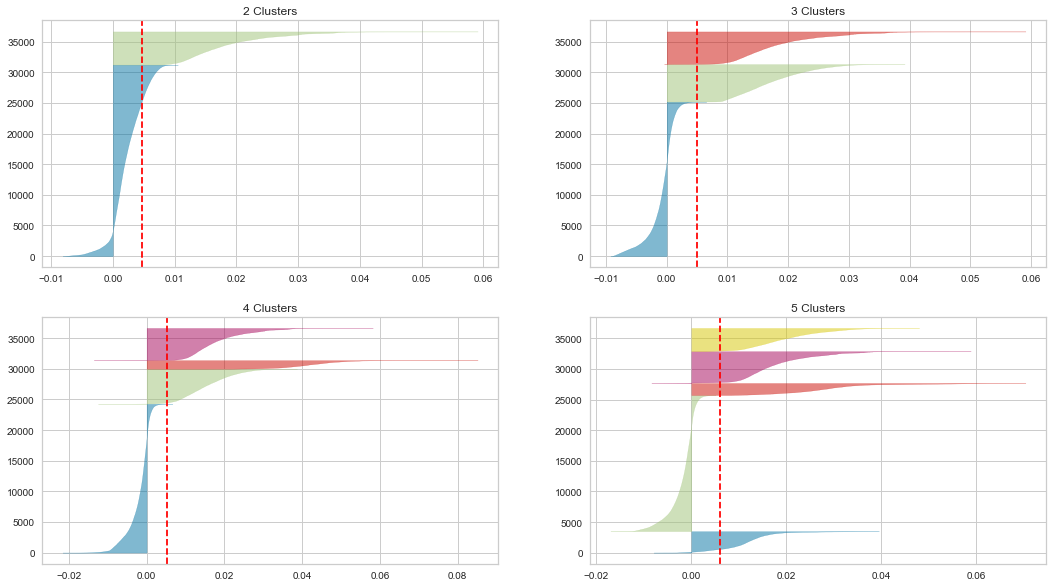

In [17]:
#using SilhouetteVisualizer to evaluate density and distance between clusters
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(18,10))
sub_coords = [(0,0), (0,1), (1,0), (1,1)]
clusters = [2, 3, 4, 5] #checking 2, 3, 4, and 5 clusters
for i in range(0, len(clusters)):
    
    km = KMeans(n_clusters=clusters[i], random_state=123)

    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[sub_coords[i][0]][sub_coords[i][1]])
    visualizer.fit(espn_df_tfidf)
    ax[sub_coords[i][0]][sub_coords[i][1]].set_title(f'{clusters[i]} Clusters')
    
plt.savefig('headlines_silhouette_plot.png')


From the silhouette plots created above, our clustering does not seem to be that effective. There is at least one cluster that far wider than the others and we don't have scores that are much larger than zero. The average silhouette score for each value of k is positive, however from the plots above it seems that a value of k=3 works best.

In [15]:
from sklearn.decomposition import TruncatedSVD

In [16]:
#use TruncatedSVD to reduce number of components to try and improve silhouette scores
pca = TruncatedSVD(n_components=100, random_state=123)
vec100 = pca.fit_transform(espn_tfidf)

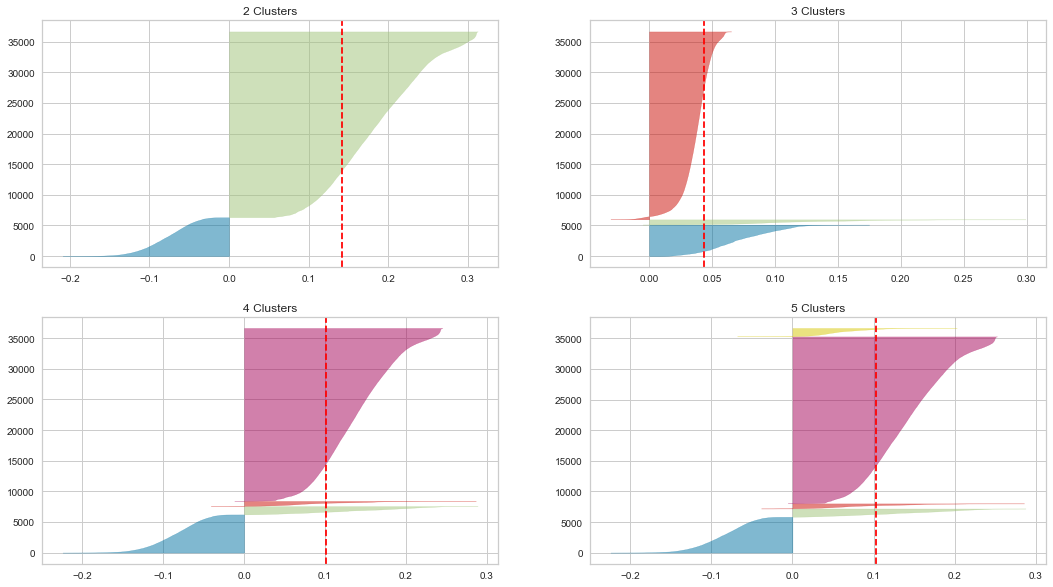

In [18]:
#creating silhouette plots using PCA transformed matrix
fig, ax = plt.subplots(2, 2, figsize=(18,10))
sub_coords = [(0,0), (0,1), (1,0), (1,1)]
clusters = [2, 3, 4, 5]
for i in range(0, len(clusters)):
    
    km = KMeans(n_clusters=clusters[i], random_state=123)

    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[sub_coords[i][0]][sub_coords[i][1]])
    visualizer.fit(vec100)
    ax[sub_coords[i][0]][sub_coords[i][1]].set_title(f'{clusters[i]} Clusters')
    
plt.savefig('headlines_pca_silhouette_plot.png')


For the silhouette plots shown above, I used the same data, except I used the TruncatedSVD algorithm prior to calculating the silhouette scores to see if the scores or shapes would improve. The scores seemed to have increased (or in some cases decreased) by an order of magnitude. Unfortunately, the shapes are still erratic so it's likely that we would need to try much larger values of k whether that be for the entire dataset or for creating subclusters within clusters.